## Intro

This notebook documents my approach to the data set. It's fairly detailed, but I don't examine all of the relationships between the variables.

It is an EDA and not a thorough analysis of all relationships! (Questions arise here and there, but it's not the aim of this notebook to answer them all.)

I am particularly interested in the general distribution and to what extent the variables are related to the target variable "total cost". In another notebook, I'll leave it to the model to estimate the exact impact of each variable.

It will be shown in the EDA that all variables affect the cost of the trip (target variable) to a greater or lesser extent. 

We'll also see: We're dealing with an incredibly diverse data set. On the one hand, we have a very large number of tourists from Tanzania's neighboring countries who only stay for a short time and spend almost no money. On the other hand, there are Western tourists who spend outrageous luxury vacations in the country. The latter are few in number, but their "extreme" values (especially when it comes to their spending) "distort" all statistics and sometimes make it very difficult to interpret the data.

For fun, at the end of the notebook, I will use a cluster algorithm to categorize the "typical" Tanzania vacationers.

| Content|
|:---|
|[Basics](#Basics) |
|[Data Cleaning](#Data-Cleaning) |
|[EDA - Hypotheses](#Hypotheses)|
|[EDA - Distributions](#Distributions)|
|[EDA - Relationships](#Relationships)|
|[Conclusion](#Conclusion)|


## Basics

In [6]:
# import some packages that I'll need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set color scheme
cpal = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]

# seaborn theme
sns.set()

# use natural numbers
pd.options.display.float_format = "{:.2f}".format


ModuleNotFoundError: No module named 'missingno'

In [8]:
# load the data
TZA = pd.read_csv('data/Train.csv')

In [9]:
# size of the data set
TZA.shape

(4809, 23)

I'm dealing with a data set of almost 5000 observations and 23 features.
Now I want to understand better what each feature means. Zindi provided a data set with feature explanations.

In [10]:
# find out what features mean
variables = pd.read_csv('data/VariableDefinitions.csv')
variables

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


In [5]:
# find out how many values are missing (per column)
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
travel_with,1114,23.16
total_female,3,0.06
total_male,5,0.10
most_impressing,313,6.51


There are many values missing for the travel_with column, almost one fourth. I'll have to learn more about this column to find out how to deal with these values. First I will check if there's a pattern. I use the missingno package for that.

In [11]:
# find out which data types I have to deal with
TZA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

I have to deal with many categorical features. This can become a bit tricky because I'll need to encode them all later (for the model). Let's check how many unique values each of these columns contain.

In [12]:
TZA.nunique()

ID                       4809
country                   105
age_group                   4
travel_with                 5
total_female               14
total_male                 14
purpose                     7
main_activity               9
info_source                 8
tour_arrangement            2
package_transport_int       2
package_accomodation        2
package_food                2
package_transport_tz        2
package_sightseeing         2
package_guided_tour         2
package_insurance           2
night_mainland             64
night_zanzibar             34
payment_mode                4
first_trip_tz               2
most_impressing             7
total_cost               1637
dtype: int64

The number of unique values of IDs is equal to the number of rows, so this already indicates clearly that there are no duplicates in the data set!

There are tourists from 105 different countries, that's lot. (It may be a good idea to group them by regions/continents later.)

There are some columns which are seemlingly intuitive to understand with each a reasonable amount of unique values, further many columns with only 2 unique values (probably yes/no).

The total_female and total_male columns I don't understand yet but I'll have a look at the dataframe now to see how these values actually look in the bigger context.

In [13]:
# have a first look
TZA.head(10)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.00,0.00,Cash,No,Friendly People,674602.50
1,tour_10,UNITED KINGDOM,25-44,NaN,1.00,0.00,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.50
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.00,1.00,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.00,31.00,Cash,No,Excellent Experience,3315000.00
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.00,0.00,Cash,Yes,Friendly People,7790250.00
4,tour_1004,CHINA,1-24,NaN,1.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.00,4.00,Cash,Yes,No comments,1657500.00
5,tour_1005,UNITED KINGDOM,25-44,NaN,0.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,No,9.00,3.00,Cash,Yes,Wildlife,120950.00
6,tour_1007,SOUTH AFRICA,45-64,Alone,0.00,1.00,Business,Mountain climbing,"Friends, relatives",Independent,...,No,No,No,No,9.00,0.00,Cash,Yes,Friendly People,466140.00
7,tour_1008,UNITED STATES OF AMERICA,45-64,Friends/Relatives,1.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,10.00,3.00,Cash,Yes,Friendly People,3480750.00
8,tour_101,NIGERIA,25-44,Alone,0.00,1.00,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,4.00,0.00,Cash,Yes,NaN,994500.00
9,tour_1011,INDIA,25-44,Alone,1.00,0.00,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,5.00,0.00,Credit Card,Yes,Friendly People,2486250.00


Ok, now things make more sense: 

Contrary to my first assumption that there is a single tourist behind each ID, there is apparently a group of tourists behind each ID (or only one tourist when travelling alone).

As expected, many columns simply contain yes/no entries.

The column travel_with, in which so many values are missing, becomes much clearer to me now: Maybe there are simply single travelers behind it? I'll check that now and impute the columns right away (for my EDA only).

I need a new column first which shows the size of travel group, I'll simply add the total_female and total_male.

In [14]:
# add new column with group size
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

Now I check whether all travel_with NaNs do have a group size of 1.

In [15]:
# check relation of NaNs (here 'missing') and group size
df_NaN = pd.crosstab(TZA['group_size'], TZA['travel_with'].fillna('missing'), normalize='index').mul(100).round(2)
df_NaN.head(50)

travel_with,Alone,Children,Friends/Relatives,Spouse,Spouse and Children,missing
group_size,,,,,,
0.00,26.67,0.00,40.00,13.33,13.33,6.67
1.00,53.10,0.04,0.55,0.55,0.00,45.76
2.00,0.00,5.88,32.34,60.36,0.56,0.87
3.00,0.00,13.46,40.71,2.88,41.67,1.28
4.00,0.38,6.04,33.96,1.13,56.98,1.51
5.00,0.00,5.43,36.96,0.00,56.52,1.09
6.00,0.00,0.00,60.78,0.00,37.25,1.96
7.00,0.00,6.25,56.25,6.25,25.00,6.25
8.00,0.00,8.33,91.67,0.00,0.00,0.00


In [16]:
df_NaN2 = pd.crosstab(TZA['travel_with'].fillna('missing'),TZA['group_size'], normalize='index').mul(100).round(2)
df_NaN2.head(50)

group_size,0.00,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,...,13.00,14.00,15.00,16.00,18.00,19.00,20.00,22.00,30.00,93.00
travel_with,,,,,,,,,,,,,,,,,,,,,
Alone,0.32,99.53,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Children,0.00,0.62,58.64,25.93,9.88,3.09,0.00,0.62,0.62,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.62
Friends/Relatives,0.68,1.46,58.90,14.30,10.14,3.83,3.49,1.01,1.24,0.68,...,0.56,0.11,0.00,0.11,0.11,0.11,0.23,0.11,0.11,0.00
Spouse,0.20,1.29,97.11,0.90,0.30,0.00,0.00,0.10,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Spouse and Children,0.54,0.00,2.45,35.33,41.03,14.13,5.16,1.09,0.00,0.27,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
missing,0.09,97.48,1.26,0.36,0.36,0.09,0.09,0.09,0.00,0.09,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


It seems that my assumption was not bad, but it doesn't cover all cases. For the imputation of the travel_with column I'll rather do the following: If the group size is 1 I'll impute with "alone", if it is bigger than 1 I'll just impute with "missing".

Looking at this also makes me aware of some other issues that I have to have a look at:
- How can a travel group consist of zero people?
- Is 93 still a reasonable group size? WHAT is a reasonable group size?
- How can a group of 4 or 15 be considered an alone traveller?
- How can a group of more than 2 be considered "travelled with spouse"? In my understanding this means a couple (of 2) was travelling...

In [17]:
# have a look at large groups
TZA[TZA['group_size'] > 10]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
246,tour_1310,SWIZERLAND,1-24,Friends/Relatives,12.00,1.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,16.00,2.00,Cash,Yes,"Wonderful Country, Landscape, Nature",21961875.00,13.00
402,tour_1491,UNITED STATES OF AMERICA,45-64,Friends/Relatives,10.00,2.00,Visiting Friends and Relatives,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,21.00,0.00,Cash,Yes,Wildlife,9116250.00,12.00
466,tour_1575,UNITED KINGDOM,45-64,Friends/Relatives,6.00,6.00,Visiting Friends and Relatives,Hunting tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,7.00,0.00,Cash,No,Friendly People,11380200.00,12.00
504,tour_1620,BELGIUM,65+,Spouse,11.00,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,No,No,14.00,0.00,Cash,Yes,Good service,7715722.00,12.00
509,tour_163,SOUTH AFRICA,25-44,Friends/Relatives,6.00,6.00,Leisure and Holidays,Beach tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,No,4.00,2.00,Cash,Yes,Friendly People,10608000.00,12.00
829,tour_2021,UNITED STATES OF AMERICA,65+,Friends/Relatives,6.00,5.00,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Package Tour,...,No,Yes,No,9.00,0.00,Cash,Yes,Friendly People,56520750.00,11.00
850,tour_2045,UNITED STATES OF AMERICA,65+,Friends/Relatives,6.00,6.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,11.00,2.00,Cash,Yes,No comments,54531750.00,12.00
1042,tour_2281,GERMANY,45-64,Alone,12.00,3.00,Scientific and Academic,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,14.00,0.00,Credit Card,No,Friendly People,32394685.75,15.00
1138,tour_2398,UNITED KINGDOM,1-24,Friends/Relatives,15.00,15.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,59.00,2.00,Cash,Yes,Friendly People,54463920.00,30.00
1194,tour_2461,CANADA,25-44,Friends/Relatives,7.00,4.00,Volunteering,Cultural tourism,others,Independent,...,No,No,No,32.00,0.00,Cash,No,Friendly People,331500.00,11.00


I don't see a pattern here. It's obvious that the combination of "alone" and a group_size greater than 1 or "spouse" with a group_size greater than 2 must be wrong. But I have no idea *which* of the columns is actually "more" correct. After all, most of them stated that they were traveling with friends/relatives. That makes sense.

I'm quite sure that the observation with 49 female and 44 male travellers (especially in the combination with "children") is wrong. 

I think a group size of up to 30 is still conceivable. My grandparents used to enjoy going on Studiosos trips and my parents-in-law like to travel with Hauser, also in quite large groups. But, if we assume that the large group sizes are the result of different couples,families,groups of friends, etc. being thrown together in a large travel group, but that the individual groups didn't actually know each other beforehand, this raises some tricky questions:
Suppose I traveled with my partner in a group (random travel group, organized by an agency) of 25 people. I state in the survey that the group consisted of 12 women and 13 men. Which group (my partner and I vs. the whole group) does my information on the total costs refer to at the end? I assume it's just my partner and me. (I probably don't have an overview of the costs for the whole group). And did all respondents answer this question consistently? Perhaps others in exactly the same situation (as a couple in a travel group) have not counted all the other travelers, but actually only themselves and their partner. I cannot answer these questions. And I can't ask anyone about it either. 

Although there are only 32 groups larger than 10, there is still the suspicion that we cannot really rely on the numbers. (Which then also applies to smaller groups).

Let's start with some 

## Data Cleaning

First I want to impute the missing values in the travel_with column with "missing"/"Alone".

In [18]:
# fill missing values with "missing"
TZA['travel_with'] = TZA['travel_with'].fillna('missing')

In [19]:
# replace travel_with by "Alone" if group size is 1
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

We saw earlier that there are also values missing in the most_impressing column. Let's have a look at the unique values of this column.

In [20]:
# check unique values in most_impressing column
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', nan,
       'Good service', 'Satisfies and Hope Come Back'], dtype=object)

There's already one value "no comments" - I'll also fill the NaN values with this one.

In [21]:
# fill missing values with "No comments"
TZA['most_impressing'] = TZA['most_impressing'].fillna('No comments')

# check again unique values
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', 'Good service',
       'Satisfies and Hope Come Back'], dtype=object)

Now let's check again if the NaNs in travel_with and most_impressing are gone...

In [22]:
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
total_female,3,0.06
total_male,5,0.10
group_size,8,0.17


They are! That's good. But there are still some values missing in the total_female and total_male columns, and our newly created column group_size also contains NaNs. This was produced by calculating with the other NaNs earlier. So we have to correct that now. 
First let's have a look at the columns with missing total_female and total_male.

In [23]:
TZA[TZA['total_female'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
490,tour_1604,FRANCE,25-44,Friends/Relatives,NaN,1.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,9.00,5.00,Cash,Yes,No comments,313000.00,NaN
545,tour_1678,ITALY,1-24,Friends/Relatives,NaN,4.00,Volunteering,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,15.00,0.00,Cash,Yes,No comments,9077320.00,NaN
1261,tour_2547,FRANCE,25-44,Friends/Relatives,NaN,1.00,Leisure and Holidays,Wildlife tourism,"Newspaper, magazines,brochures",Package Tour,...,Yes,Yes,Yes,7.00,7.00,Cash,Yes,"Wonderful Country, Landscape, Nature",324300.00,NaN


In [24]:
TZA[TZA['total_male'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
1017,tour_2246,UNITED STATES OF AMERICA,45-64,Friends/Relatives,4.00,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,19.00,0.00,Cash,Yes,No comments,7293000.00,NaN
1473,tour_2810,SPAIN,45-64,Friends/Relatives,7.00,NaN,Other,Hunting tourism,"Travel, agent, tour operator",Package Tour,...,No,No,Yes,11.00,0.00,Cash,No,"Wonderful Country, Landscape, Nature",56960183.00,NaN
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.00,NaN,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.00,0.00,Credit Card,Yes,Friendly People,3978000.00,NaN
2494,tour_4031,FRANCE,25-44,missing,0.00,NaN,Leisure and Holidays,Conference tourism,"Radio, TV, Web",Package Tour,...,Yes,Yes,Yes,6.00,0.00,Cash,Yes,Excellent Experience,4309500.00,NaN
3984,tour_5838,CHINA,25-44,Friends/Relatives,10.00,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,4.00,2.00,Cash,Yes,Wildlife,89505000.00,NaN


For lack of other clues, I'll just assume that in these cases NaN equals 0. I'll impute these NaNs accordingly.

In [25]:
# fill missing values with 0
TZA['total_male'] = TZA['total_male'].fillna(0)
TZA['total_female'] = TZA['total_female'].fillna(0)

Now I'll apply the group_size calculation again.

In [26]:
# calculate group size again
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

I also replace once again travel_with by Alone if the group size is 1.

In [27]:
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

In [28]:
# check again for missing values 
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


Great! No more missing values!

We saw some other irregularities before. There were group sizes of zero. Let's have a look at them.

In [29]:
TZA.loc[TZA['group_size'] == 0]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
170,tour_1205,UNITED STATES OF AMERICA,25-44,Spouse,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Radio, TV, Web",Package Tour,...,No,Yes,No,5.00,4.00,Credit Card,No,Excellent Experience,1657500.00,0.00
705,tour_1867,HUNGARY,45-64,Spouse and Children,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,4.00,0.00,Cash,Yes,Wildlife,7646047.50,0.00
706,tour_1869,UNITED STATES OF AMERICA,45-64,missing,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,7.00,0.00,Cash,Yes,No comments,21713250.00,0.00
727,tour_1893,UNITED STATES OF AMERICA,45-64,Spouse and Children,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,20.00,0.00,Cash,Yes,Friendly People,19227000.00,0.00
1154,tour_2414,GERMANY,45-64,Friends/Relatives,0.00,0.00,Leisure and Holidays,Beach tourism,"Newspaper, magazines,brochures",Package Tour,...,No,No,No,0.00,33.00,Cash,Yes,Wildlife,67399101.00,0.00
1670,tour_3040,ZIMBABWE,1-24,Alone,0.00,0.00,Business,Beach tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,2.00,0.00,Cash,No,No comments,500000.00,0.00
2243,tour_3730,UNITED STATES OF AMERICA,65+,Spouse,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,No,No,14.00,0.00,Cash,Yes,Wildlife,16939650.00,0.00
2335,tour_3840,SPAIN,25-44,Alone,0.00,0.00,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,No,4.00,0.00,Cash,Yes,"Wonderful Country, Landscape, Nature",447525.00,0.00
2430,tour_396,AUSTRALIA,1-24,Alone,0.00,0.00,Leisure and Holidays,Hunting tourism,"Travel, agent, tour operator",Independent,...,No,No,No,15.00,5.00,Cash,Yes,Friendly People,11027030.00,0.00
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.00,0.00,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.00,0.00,Credit Card,Yes,Friendly People,3978000.00,0.00


So for these 17 observations we don't have the information how big the travel group was. We can assume that those who travelled "alone" were 1, and those who travelled with "spouse" were 2. 
We don't know for sure, and it's only 17 observations. I'll just remove these rows for my EDA.

In [30]:
# only keep rows with group size greater than 0
TZA = TZA[TZA.group_size > 0]

# check whether 17 rows were deleted
TZA.shape

(4792, 24)

In an earlier version of this EDA I wanted to delete all columns, in which the travel_with and group_size columns obviously don't make sense together:
- Alone travellers with group size not equal to 1
- With Spouse travellers with group size not equal to 2
  
However, I am now deciding against this, as I have considerable doubts about the consistency of the information on group size. I believe that in many cases this refers to a larger group, whereas - and this is the decisive factor - the information on total costs usually only refers to my core group.

Now it's time to check for obvious outliers. I'll plot boxplots for the numeric features in my data set. (*not meant to be super beautiful, only for my better understanding*)

Let's start with the group size:

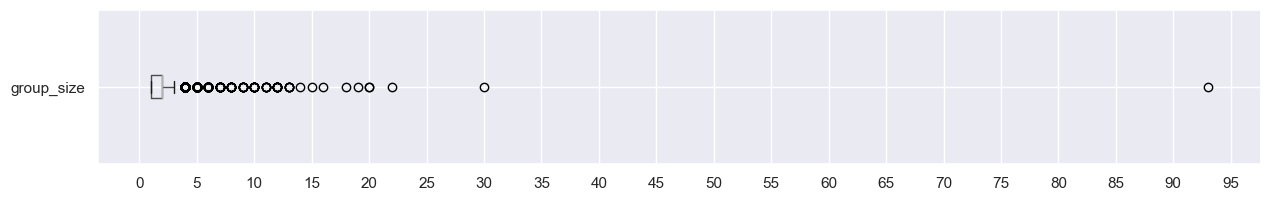

In [31]:
TZA.boxplot(column='group_size', vert=False, figsize=[15, 2])
max_value = TZA['group_size'].max()
tick_positions = np.arange(0, int(max_value) + 5, step=5)
plt.xticks(tick_positions)
plt.show()

We see here that the data is very concentrated in the area of small groups. To the right there are some outliers. (We already know some of them.) It is logical that we cannot have any outliers to the left, since the group size cannot be smaller than 1. 
Outliers are determined using the [IQR method](https://online.stat.psu.edu/stat200/lesson/3/3.2#:~:text=We%20can%20use%20the%20IQR,add%20this%20value%20to%20Q3.). It doesn't mean that this data has to be wrong. Just that they are atypical for this data set.
We will plot the group size differently later to better illustrate the distribution. 

Let's have a look at the number of nights that travellers spend on the mainland.

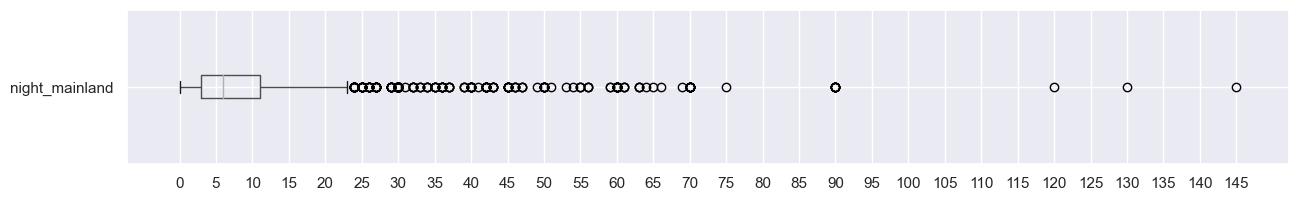

In [32]:
TZA.boxplot(column='night_mainland', vert=False, figsize=[15, 2])
max_value = TZA['night_mainland'].max()
tick_positions = np.arange(0, int(max_value) + 5, step=5)
plt.xticks(tick_positions)
plt.show()

Here we see that 50% of visitor groups stay on the mainland between 3 and 11 nights. The median is 6 nights, which means half of the visitors stay less than 6 nights and the other half stay longer than 6 nights. The area of outliers begins after 23 nights. There are quite a few of them.

Let's have a look at the number of nights that travellers spend on Zanzibar.

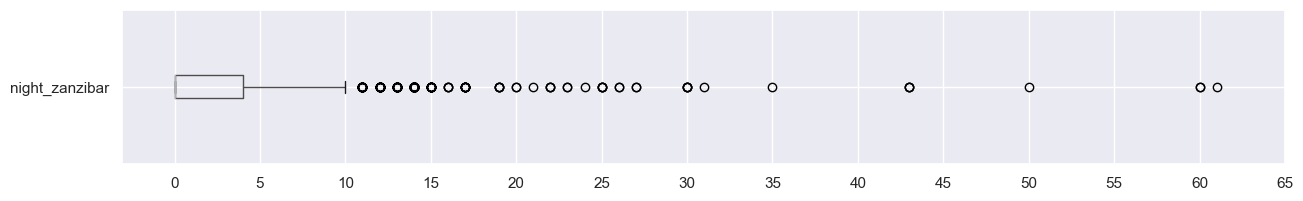

In [33]:
TZA.boxplot(column='night_zanzibar', vert=False, figsize=[15, 2])
max_value = TZA['night_zanzibar'].max()
tick_positions = np.arange(0, int(max_value) + 5, step=5)
plt.xticks(tick_positions)
plt.show()

The median here is 0. So at least half of the visitors do not visit Zanzibar at all. 25% of visitors visit Zanzibar for 4-65 nights.

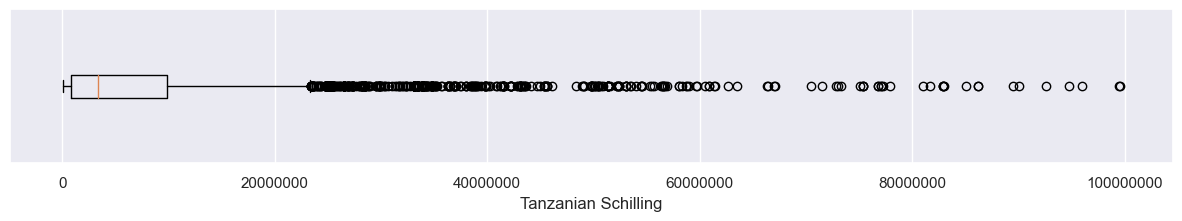

In [34]:
plt.figure(figsize=[15, 2])
plt.boxplot(TZA['total_cost'], vert=False)
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('Tanzanian Schilling')
plt.yticks([])
plt.show();

There is a wide spread in costs. The maximum value of 100000000 TZA corresponds to the equivalent of approx. 37400 EUR! At the same time, the median is more like (the equivalent of) 1200 EUR. That means half of visitors spend less than this amount. We have an extremely large number of outliers. But many of them are probably correct. We will of course look at this important variable in more detail later.

I also check the basic statistics:

In [41]:
TZA.describe()

,total_female,total_male,night_mainland,night_zanzibar,total_cost,group_size
count,4792.00,4792.00,4792.00,4792.00,4792.00,4792.00
mean,0.93,1.01,8.49,2.30,8096646.64,1.94
std,1.29,1.14,10.44,4.21,12208471.16,2.08
min,0.00,0.00,0.00,0.00,49000.00,1.00
25%,0.00,1.00,3.00,0.00,804548.38,1.00
50%,1.00,1.00,6.00,0.00,3357182.50,2.00
75%,1.00,1.00,11.00,4.00,9824831.25,2.00
max,49.00,44.00,145.00,61.00,99532875.00,93.00


Is it realistic that a travel group consists of 93? Or that a group spends almost 40.000 € for their holidays? That someone stays almost 5 months on holidays?

We see extreme, unusual numbers for all numerical variables. But we must also assume that many of them are absolutely correct. Distinguishing which of the numbers are simply extreme but correct and which are really wrong is a major challenge. I will keep the outliers for the EDA for now. If applicable. I will remove them in individual plots.

## EDA

Before I start with the EDA I come up with some...

### Hypotheses

- The bigger a group is, the more money they spend.
- The longer a group stays, the more money they spend.
- The more extras a group books, the more money they spend.
- Arranged tours are more expensive than independent tours.
- Tourists from wealthier countries spend more money.
- Older tourists spend more than younger tourists.
- The purpose of the tour has an impact on how much money a group spends.

Let's start with exploring the data. First we want to understand the distributions better, later we'll check the relationships between the features, especially towards the target variable.

### Distributions

Let's start with the countries. We have tourists from 105 different countries in our data set!

I'll now add the subregions to my original dataframe. For this step it is important that the country names in both data frames are exactly the same. In the other notebook Get_regions I created a sheet with country names and subregions. I need to standardize the spelling of the countries in both data sets so that they can be matched.

In [37]:
# change to lower cases
TZA['country'] = TZA['country'].str.lower()

In [38]:
# change some country names
TZA = TZA.replace({'country' : {'united states of america': 'united States', 'swaziland' : 'eswatini', 'cape verde' : 'cabo verde', 'swizerland' : 'switzerland', 'ukrain' : 'ukraine','malt' : 'malta', 'burgaria' : 'bulgaria', 'korea' : 'south korea', 'comoro' : 'comoros', 'scotland' : 'united kingdom', 'russia' : 'russia', 'srilanka': 'sri lanka'}})
TZA = TZA.replace({'country' : {'ivory coast': "côte d'ivoire", 'drc' : 'congo', 'uae' : 'united arab emirates', 'trinidad tobacco' : 'trinidad and tobago', 'costarica' : 'costa rica', 'philipines' : 'philippines', 'djibout' : 'djibouti', 'morroco' : 'morocco'}})

In [39]:
# capitalize first letter
TZA['country'] = TZA['country'].str.capitalize()

In [40]:
# get subregions and delete unnecessary column
subregions = pd.read_csv('data/subregions.csv')
subregions.drop(['Unnamed: 0'], axis=1, inplace=True)
subregions

FileNotFoundError: [Errno 2] No such file or directory: 'data/subregions.csv'

In [36]:
# merge the subregions into the TZA dataframe
TZA = pd.merge(TZA, subregions, how ='left')

NameError: name 'subregions' is not defined

Let's first have a look at the distribution of countries.

In [42]:
# get percentages and counts per country
percentage_c = TZA['country'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
counts_c = TZA['country'].value_counts()

# concatenate percentages and counts in a new dataframe and show it
countries = pd.concat([counts_c,percentage_c], axis=1, keys=['count', 'percentage'])
countries

,count,percentage
country,,
United states,691,14.4%
United kingdom,536,11.2%
Italy,393,8.2%
France,278,5.8%
Zimbabwe,273,5.7%
...,...,...
Niger,1,0.0%
Myanmar,1,0.0%
Dominica,1,0.0%


Most visitors come from US and UK. Let's print the top 10 countries with most tourists.

In [45]:
# function to print percentages on the horizontal plot

def plot_percentage_hor(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

In [44]:
# plot the top 10 countries

country_order = TZA['country'].value_counts().head(10).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, y='country', order=country_order, color = "#f9c74f")
plot_percentage_hor(ax, TZA.age_group)
plt.title('From which countries do tourists come? (Top 10)')
plt.xlabel('No. of tourists')
plt.ylabel('Country');

And now I do the same for the subregions!

In [46]:
# get percentages and counts per subregion

percentage_s = TZA['sub_region'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
counts_s = TZA['sub_region'].value_counts()

# concatenate percentages and counts in a new dataframe and show it
sub_regions = pd.concat([counts_s,percentage_s], axis=1, keys=['count', 'percentage'])
sub_regions

KeyError: 'sub_region'

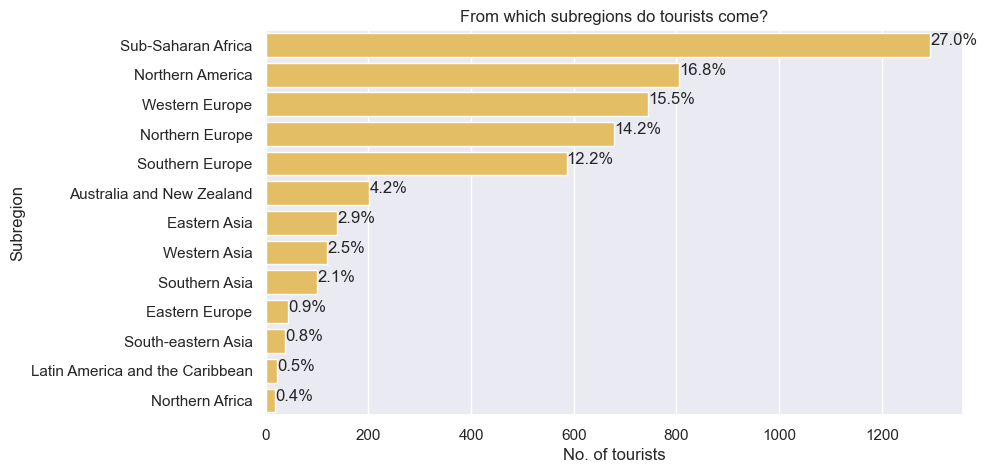

In [41]:
# plot the subregions

subregion_order = TZA['sub_region'].value_counts().head(TZA['sub_region'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, y='sub_region', order=subregion_order, color = "#f9c74f")
plot_percentage_hor(ax, TZA.sub_region)
plt.title('From which subregions do tourists come?')
plt.xlabel('No. of tourists')
plt.ylabel('Subregion');

We have seen that most of the tourists are from US and UK. When we then had a look at the tourists per sub-region, we saw that by far most of them come from Tanzania's own region, sub-Saharan Africa.

Now let's have a look at the age groups.

In [42]:
# function to print percentages on the vertical plot

def plot_percentage_ver(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

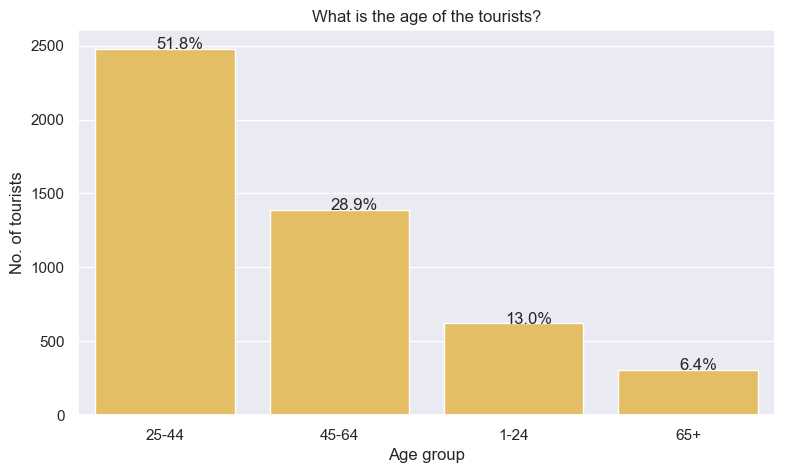

In [43]:
# plot the age groups

age_order = TZA['age_group'].value_counts().head(TZA['age_group'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, x='age_group', order=age_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.age_group)
plt.title('What is the age of the tourists?')
plt.xlabel('Age group')
plt.ylabel('No. of tourists');

Most tourists are young or middle aged adults.

Now let's see who the tourists usually travel with.

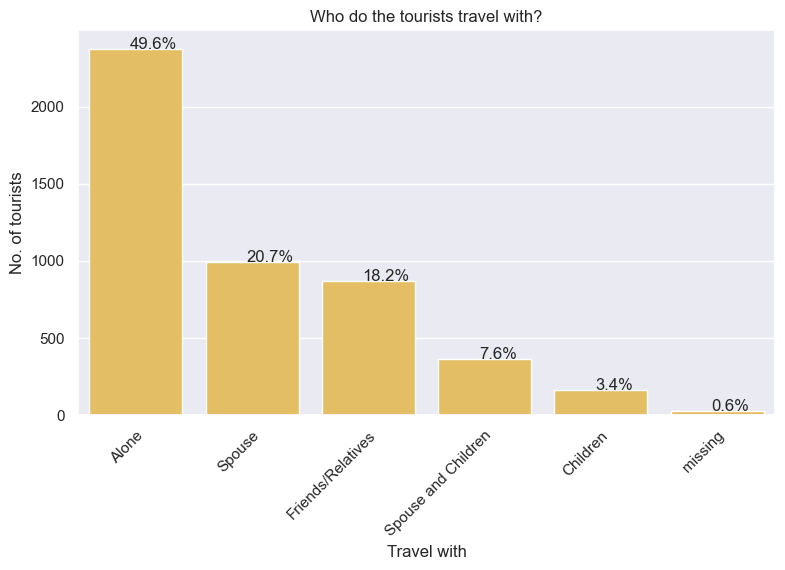

In [44]:
# plot travel with

travel_with_order = TZA['travel_with'].value_counts().head(TZA['travel_with'].nunique()).index
plt.figure(figsize=(9, 5))
ax = sns.countplot(data=TZA, x='travel_with', order=travel_with_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.travel_with)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Who do the tourists travel with?')
plt.xlabel('Travel with')
plt.ylabel('No. of tourists');

Almost half of the tourists travel alone. We also wanted to have a closer look at the group sizes which we do now:

In [45]:
# define bins and labels
bins_gs = [0,1,2,5,10,15,100]
labels_gs = ['1 traveller','2 travellers', '3-5 travellers', '6-10 travellers', '11-15 travellers', 'more than 15 travellers']

# bin accordingly
TZA['group_size_binned'] = pd.cut(TZA['group_size'], bins=bins_gs, labels=labels_gs)

# have a look on these columns together
TZA[['group_size', 'group_size_binned']].head()

,group_size,group_size_binned
0,2.00,2 travellers
1,1.00,1 traveller
2,1.00,1 traveller
3,2.00,2 travellers
4,1.00,1 traveller


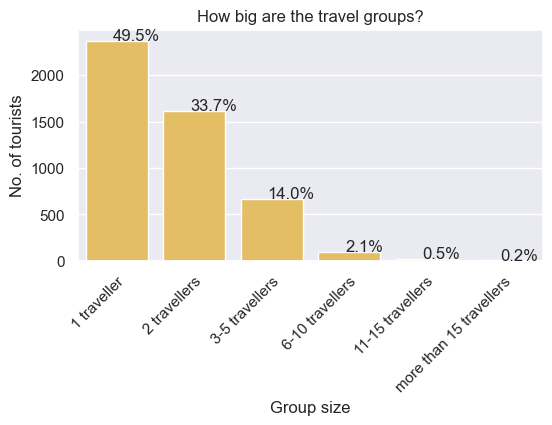

In [46]:
# group_size
group_size_binned_order = TZA['group_size_binned'].value_counts().head(TZA['group_size_binned'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='group_size_binned', order=group_size_binned_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.group_size_binned)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('How big are the travel groups?')
plt.xlabel('Group size')
plt.ylabel('No. of tourists');

This confirms that we saw already in the boxplot. By far most tourists travel alone or in very small groups. We still don't know how the large travel groups with more than 10 participants come about. Error in data collection? Certainly not in all cases. In any case, we can say that it only affects very few observations at all. 


Now let's plot some more of the categorical variables.

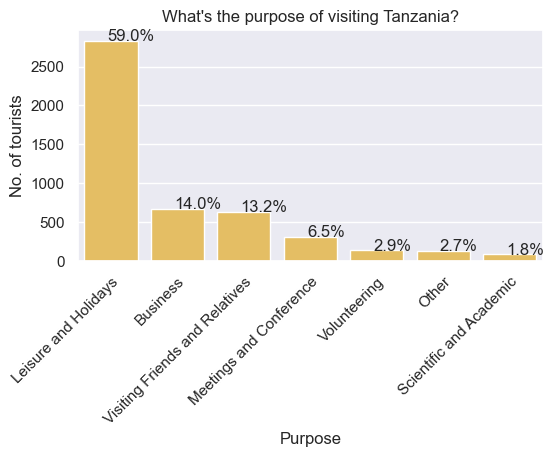

In [47]:
# purpose of travel
purpose_order = TZA['purpose'].value_counts().head(TZA['purpose'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='purpose', order=purpose_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.purpose)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the purpose of visiting Tanzania?')
plt.xlabel('Purpose')
plt.ylabel('No. of tourists');

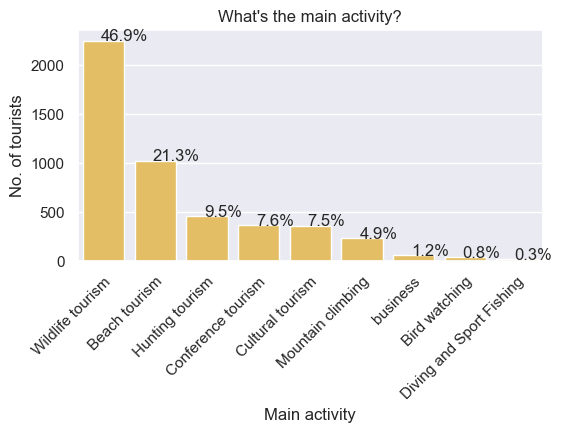

In [48]:
# main_activity
main_activity_order = TZA['main_activity'].value_counts().head(TZA['main_activity'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='main_activity', order=main_activity_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.main_activity)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the main activity?')
plt.xlabel('Main activity')
plt.ylabel('No. of tourists');

Most tourists visited Tanzania for Leisure and Holidays, with Wildlife tourism being the most important activity. 

During my first attempts with the model, I asked myself whether I needed both columns. My thought was that the information would overlap a lot here. So whoever comes with Purpose Business will certainly also have the Main Activity Business, etc. Unfortunately, I was wrong:

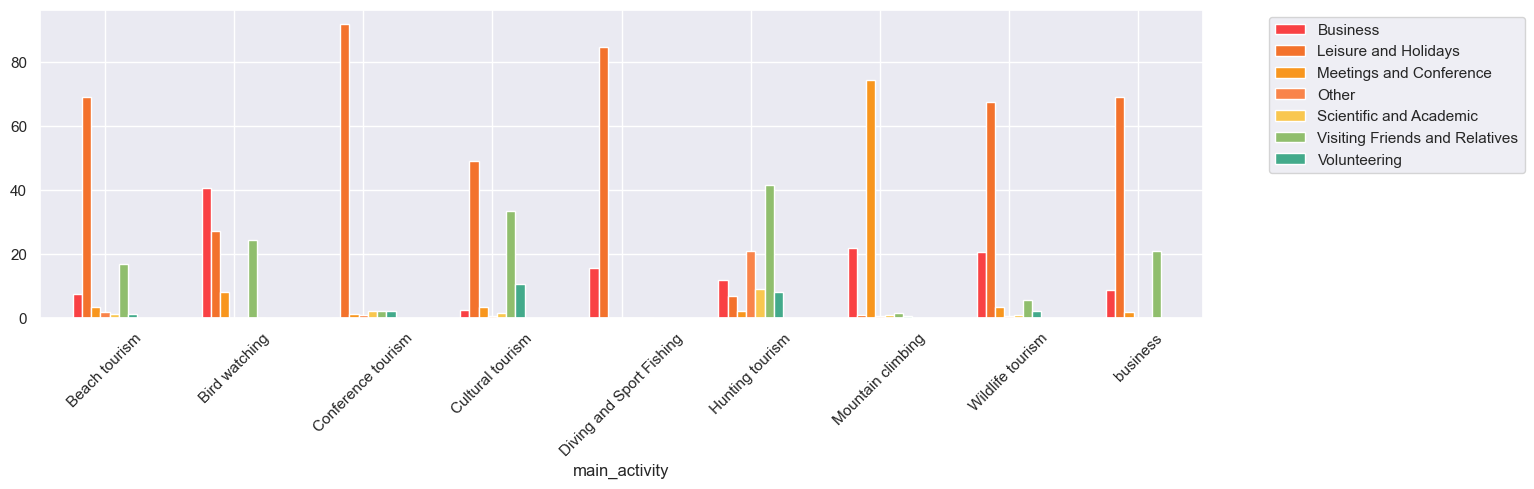

In [49]:
purpose_activity = pd.crosstab(TZA['main_activity'], TZA['purpose'], normalize = 'index').mul(100).round(2)
purpose_activity.plot.bar(figsize=(15,4), rot=45, color=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

The main activity on the trip is bird watching, but the actual purpose of the trip is business?

The main activity on the trip is conference tourism, but the actual purpose of the trip is leisure and holidays? Ok, you can also attend conferences privately and with pleasure and that is also a vacation, but why not choose meetings and conferences as the purpose then?

The main activity on the trip is mountain climbing, but the actual purpose of the trip is meetings and conferences? 

The main activity on the trip is business, but the actual purpose of the trip is leisure and holidays? Why not business?

For me, none of this fits together. And if we look at it the other way around, the picture doesn't get any better:

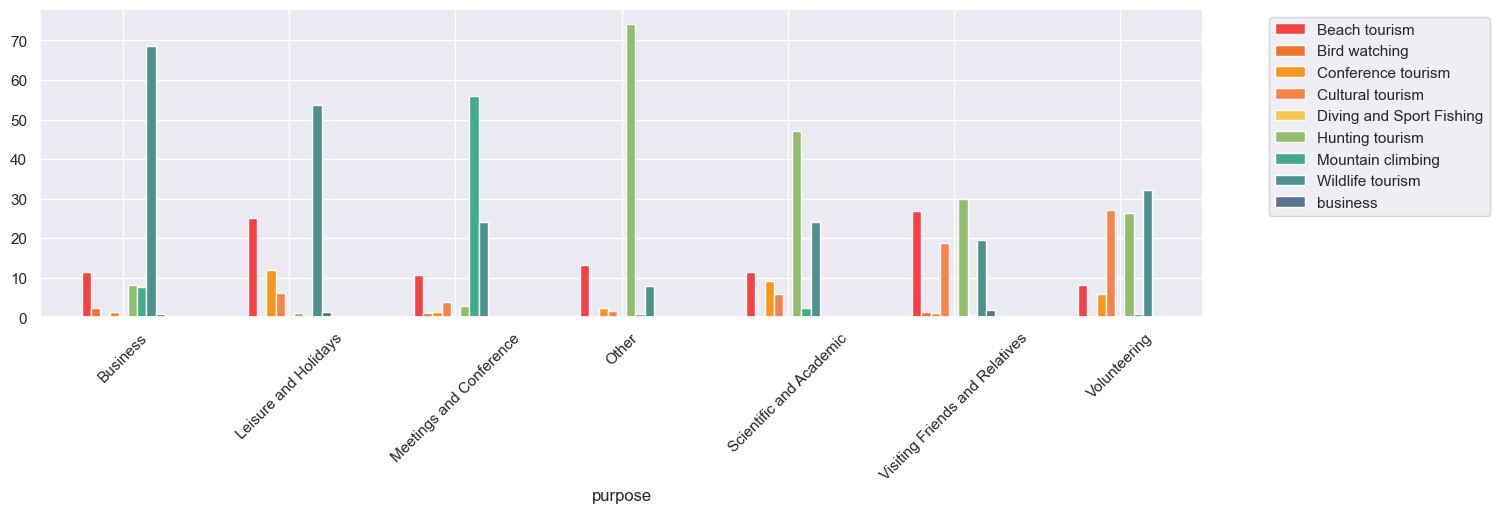

In [50]:
purpose_activity2 = pd.crosstab(TZA['purpose'], TZA['main_activity'], normalize = 'index').mul(100).round(2)
purpose_activity2.plot.bar(figsize=(15,4), rot=45, color=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

Main activity of those who reply they come for business is wildlife tourism? 

Main acitvity of those who reply they come for meetings and conference is mountain climbing?

Main acitvity of those who reply they come for scientific and acamdemic is hunting?

For me these columns do not make much sense together. As often, we do not know which of the columns is actually the faulty one. Otherwise we could just get rid of one of them... I can imagine that these contradicting responses will add a lot of confusion to the model.

Now let's see which source the tourists mostly use for information.

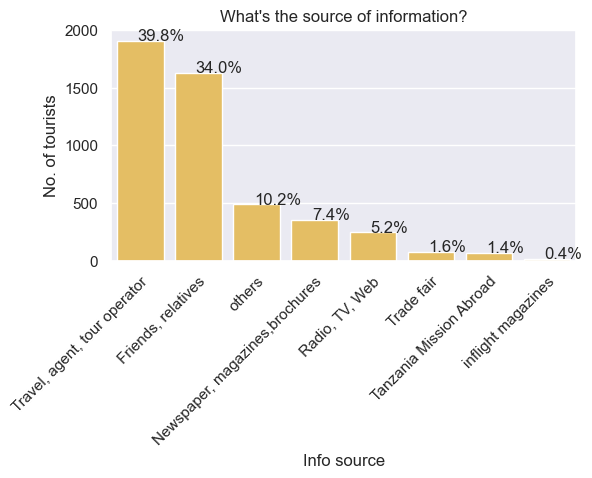

In [51]:
# info_source
info_source_order = TZA['info_source'].value_counts().head(TZA['info_source'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='info_source', order=info_source_order, color = "#f9c74f")
plot_percentage_ver(ax, TZA.info_source)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the source of information?')
plt.xlabel('Info source')
plt.ylabel('No. of tourists');

Interesting that "web" (in one category with radio and TV) doesn't seem to play a big role here.

Now I check wheather tourists book their holidays independently or as a package/arrangement:

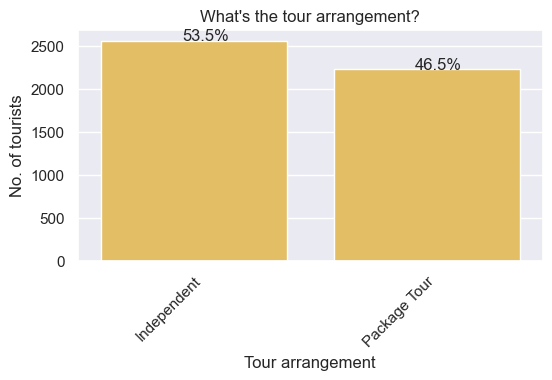

In [52]:
# tour_arrangement
tour_arrangement_order = TZA['tour_arrangement'].value_counts().head(TZA['tour_arrangement'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='tour_arrangement', order=tour_arrangement_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.tour_arrangement)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What\'s the tour arrangement?')
plt.xlabel('Tour arrangement')
plt.ylabel('No. of tourists');

Slightly more tourists travel independently. 

Now I want to check those who booked a package: Which services were included? I first create a new dataframe with the relevant columns only.

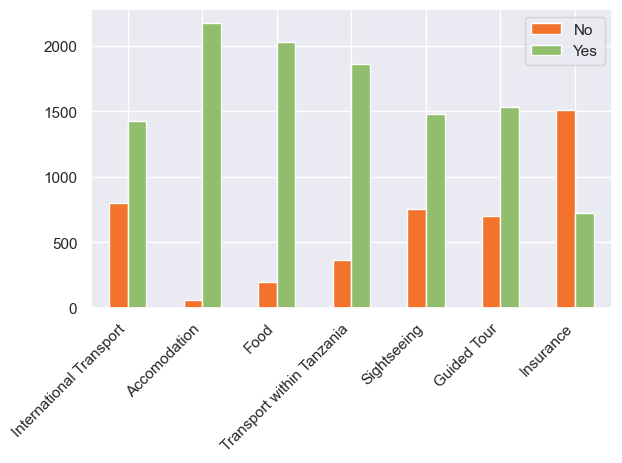

In [53]:
# create new dataframe
tourarrangement = TZA[['tour_arrangement','package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance']].copy()

# filter on those with package
packages_tourarrangements = tourarrangement[(tourarrangement.tour_arrangement == 'Package Tour')]
#remove tour_arrangement column
packages_tourarrangements = packages_tourarrangements.drop(['tour_arrangement'], axis=1)

#plot which services were booked
packages_tourarrangements_num = packages_tourarrangements.apply(pd.value_counts).T
ax=packages_tourarrangements_num.plot.bar(color = {'Yes': "#90be6d", 'No':'#f3722c'}, edgecolor='White')
ax.set_xticklabels(['International Transport', 'Accomodation',
       'Food', 'Transport within Tanzania', 'Sightseeing',
       'Guided Tour', 'Insurance'], rotation=45, ha="right")
#needs improvement
# for col in packages_num.columns:
#    plot_percentage_ver(ax, col)
plt.tight_layout()
plt.show();

We see that most packages include accomodation, followed by food and transport in Tanzania. Most tourists didn't book an insurance.

Now I want to have a look into the duration of stay. For this I will first sum the nights on mainland and on Zanzibar and then bin the durations in buckets of weeks.

In [54]:
# create new column with total nights
TZA['total_nights'] = TZA['night_mainland'] + TZA['night_zanzibar']

There are rows with total nights = 0. This doesn't make any sense. I'll delete those rows now.

In [55]:
# find the indexes of the rows where total nights equals 0
index_no_nights = TZA[ (TZA['total_nights'] == 0)].index

# drop these rows
TZA.drop(index_no_nights, inplace=True)

In [56]:
# define bins and labels
bins = [-1,0,7,14,21,28,56,1000]
labels = ['none','up to 1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '4-8 weeks', 'more than 8 weeks']

bins_total = [0,7,14,21,28,56,1000]
labels_total = ['up to 1 week', '1-2 weeks', '2-3 weeks', '3-4 weeks', '4-8 weeks', 'more than 8 weeks']

# bin all nights columns accordingly
TZA['nights_mainland_binned'] = pd.cut(TZA['night_mainland'], bins=bins, labels=labels)
TZA['nights_zanzibar_binned'] = pd.cut(TZA['night_zanzibar'], bins=bins, labels=labels)
TZA['total_nights_binned'] = pd.cut(TZA['total_nights'], bins=bins_total, labels=labels_total)

# have a look on these columns together
TZA[['night_mainland', 'nights_mainland_binned', 'night_zanzibar', 'nights_zanzibar_binned', 'total_nights', 'total_nights_binned']]

,night_mainland,nights_mainland_binned,night_zanzibar,nights_zanzibar_binned,total_nights,total_nights_binned
0,13.00,1-2 weeks,0.00,none,13.00,1-2 weeks
1,14.00,1-2 weeks,7.00,up to 1 week,21.00,2-3 weeks
2,1.00,up to 1 week,31.00,4-8 weeks,32.00,4-8 weeks
3,11.00,1-2 weeks,0.00,none,11.00,1-2 weeks
4,7.00,up to 1 week,4.00,up to 1 week,11.00,1-2 weeks
...,...,...,...,...,...,...
4787,2.00,up to 1 week,0.00,none,2.00,up to 1 week
4788,11.00,1-2 weeks,0.00,none,11.00,1-2 weeks
4789,3.00,up to 1 week,7.00,up to 1 week,10.00,1-2 weeks
4790,5.00,up to 1 week,0.00,none,5.00,up to 1 week


And now let's plot the total nights.

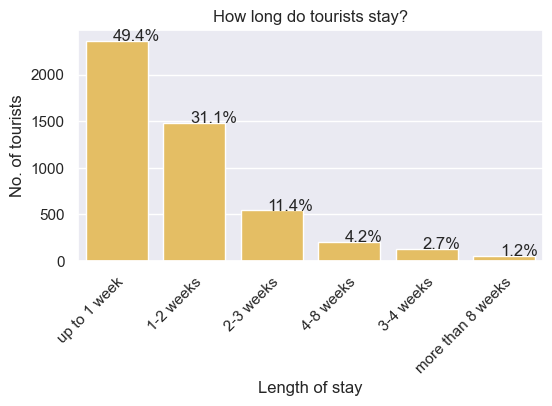

In [57]:
# total_nights
total_nights_binned_order = TZA['total_nights_binned'].value_counts().head(TZA['total_nights_binned'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='total_nights_binned', order=total_nights_binned_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.total_nights_binned)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('How long do tourists stay?')
plt.xlabel('Length of stay')
plt.ylabel('No. of tourists');

Most tourists don't stay very long, almost half of them for a week at most. Not even 20 percent stay longer than 2 weeks.

Now let's check the payment modes.

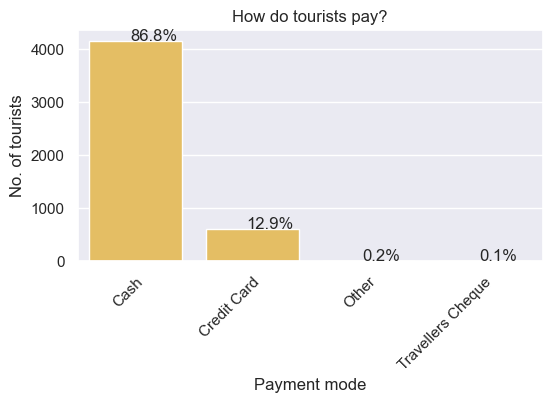

In [58]:
# payment_mode
payment_mode_order = TZA['payment_mode'].value_counts().head(TZA['payment_mode'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='payment_mode', order=payment_mode_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.payment_mode)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('How do tourists pay?')
plt.xlabel('Payment mode')
plt.ylabel('No. of tourists');

By far most pay cash.

Now I check how many tourists visit Tanzania for the first time.

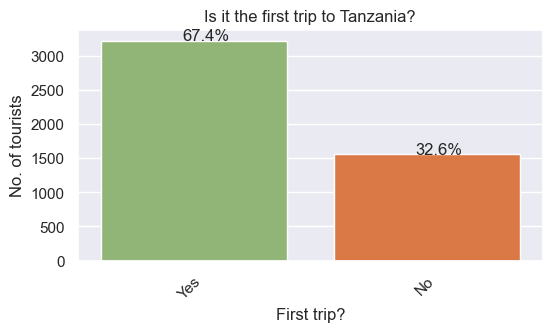

In [59]:
# first_trip_tz
first_trip_tz_order = TZA['first_trip_tz'].value_counts().head(TZA['first_trip_tz'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='first_trip_tz', order=first_trip_tz_order, palette = ["#90be6d", '#f3722c'])
plot_percentage_ver(ax, TZA.first_trip_tz)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('Is it the first trip to Tanzania?')
plt.xlabel('First trip?')
plt.ylabel('No. of tourists');

67% visit Tanzania for the first time.

What impresses tourists most when visiting Tanzania?

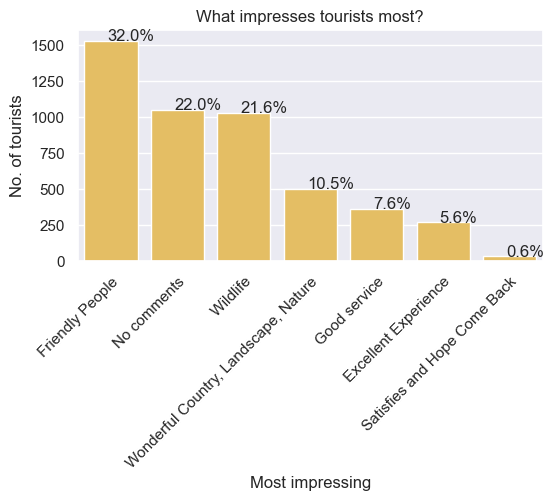

In [60]:
# most_impressing
most_impressing_order = TZA['most_impressing'].value_counts().head(TZA['most_impressing'].nunique()).index
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=TZA, x='most_impressing', order=most_impressing_order, color = '#f9c74f')
plot_percentage_ver(ax, TZA.most_impressing)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('What impresses tourists most?')
plt.xlabel('Most impressing')
plt.ylabel('No. of tourists');

Most tourists were impressed by the friendy people.

And now let's check the final column, our target variable late for the model: the total cost! The column in the data set is in Tanzanian Schilling. I convert it to Euro, so it is easier for me to understand the numbers.

In [61]:
TZA['total_cost_Euro'] = TZA['total_cost'] * 0.00038

For the plot I remove the values > 25000.

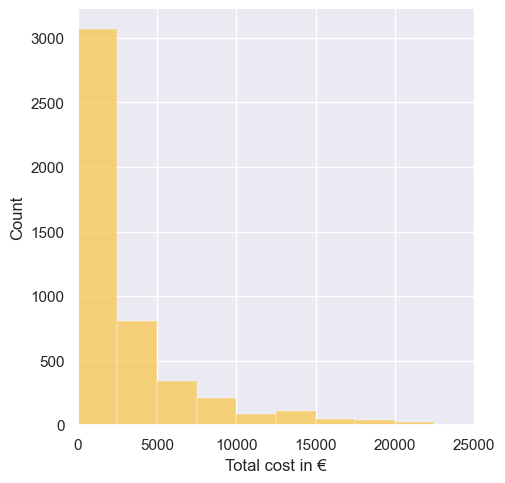

In [62]:
g = sns.displot(
  data=TZA,
  x="total_cost_Euro",
  kind="hist", 
  bins=[18.615, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 37822.495], color = '#f9c74f')
plt.xlabel('Total cost in €')
plt.xlim(0,25000);

Most tourist groups spend up to 2500 € for their trip.

I'll also check the cost per night now. For this, I simply divide the total cost (in Euro) by the total nights. 

In [63]:
TZA['cost_per_night_Euro'] = TZA['total_cost_Euro'] / TZA['total_nights']

Because of the outliers, I only include the values between the 5th and 95th percentiles in the graph:

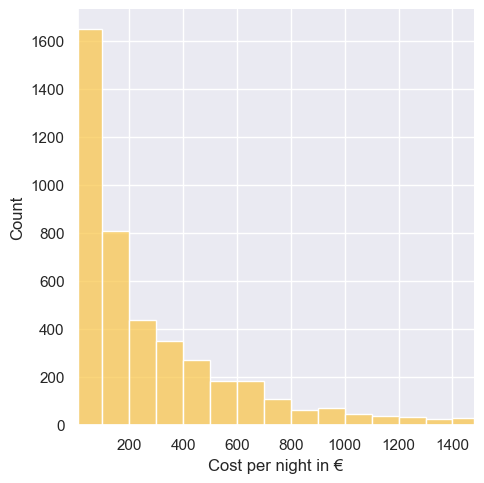

In [64]:
g = sns.displot(
  data=TZA,
  x="cost_per_night_Euro",
  kind="hist", 
  bins=[8.745, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1480.15], color = '#f9c74f')
plt.xlabel('Cost per night in €')
plt.xlim(TZA['cost_per_night_Euro'].quantile(.05).round(2),TZA['cost_per_night_Euro'].quantile(.95).round(2));

### Relationships

So far, we have looked at the individual features independently. Now we want to see how they relate to each other, if there are correlations, etc.

Let's start with a simple correlation heatmap. (We can only show numeric features in a correlation matrix.)

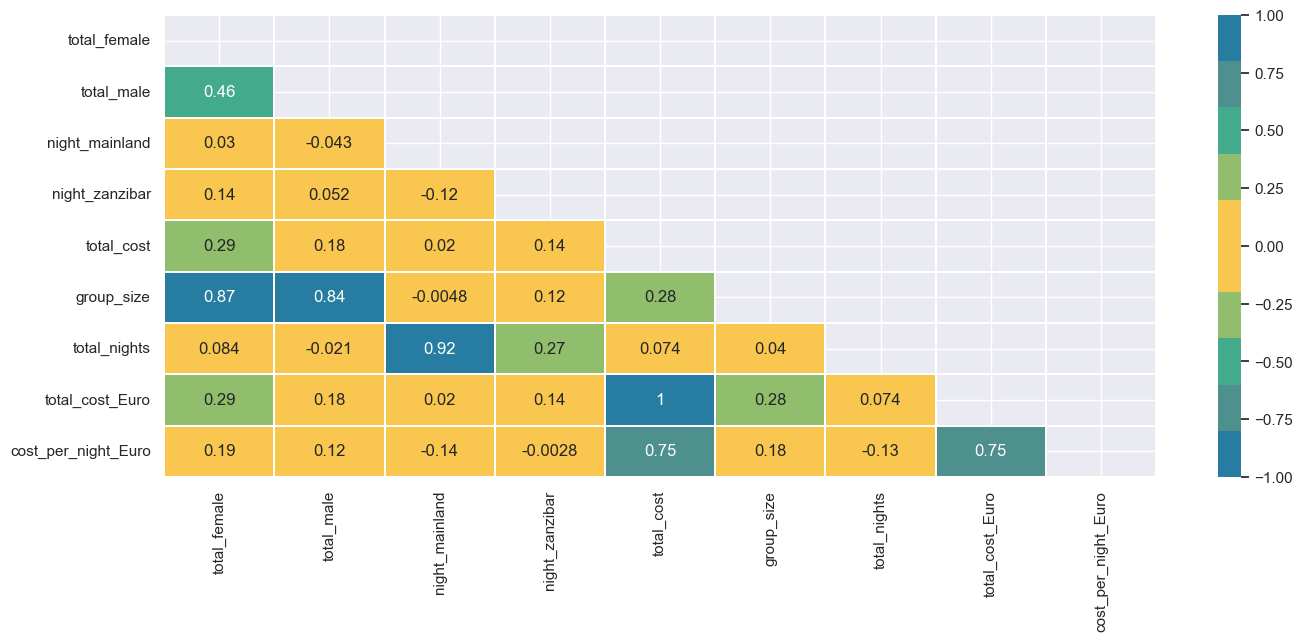

In [65]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(TZA.corr(numeric_only=True), dtype=bool))
correlations = sns.heatmap(TZA.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, linewidths=0.005, linecolor='white', cmap = ['#277da1', '#4d908e', '#43aa8b', '#90be6d', '#f9c74f', '#f9c74f', '#90be6d','#43aa8b', '#4d908e', '#277da1'], mask=mask);

This plot shows us the correlation coefficients between the numeric features. A coefficient of 1 means perfect positive correlation, -1 means perfect negative correlation and 0 means no correlation at all.

We see:
- very strong correlation between group size and total_male
- very strong correlation between group size and total_female
- moderate correlation between total_male and total_female
- weak correlation between group size/total_female/total_male and total_cost

total_cost is our target variable and we aim to find out by which features it is influenced. 
It's interesting that it is not that much influenced by the travel group size and even less by the nights spent in Tanzania. These were hypotheses earlier, and I must say I really believed these features were more influencing. 

Now let's make some scatterplots to visualize the relationships between the numerical features.

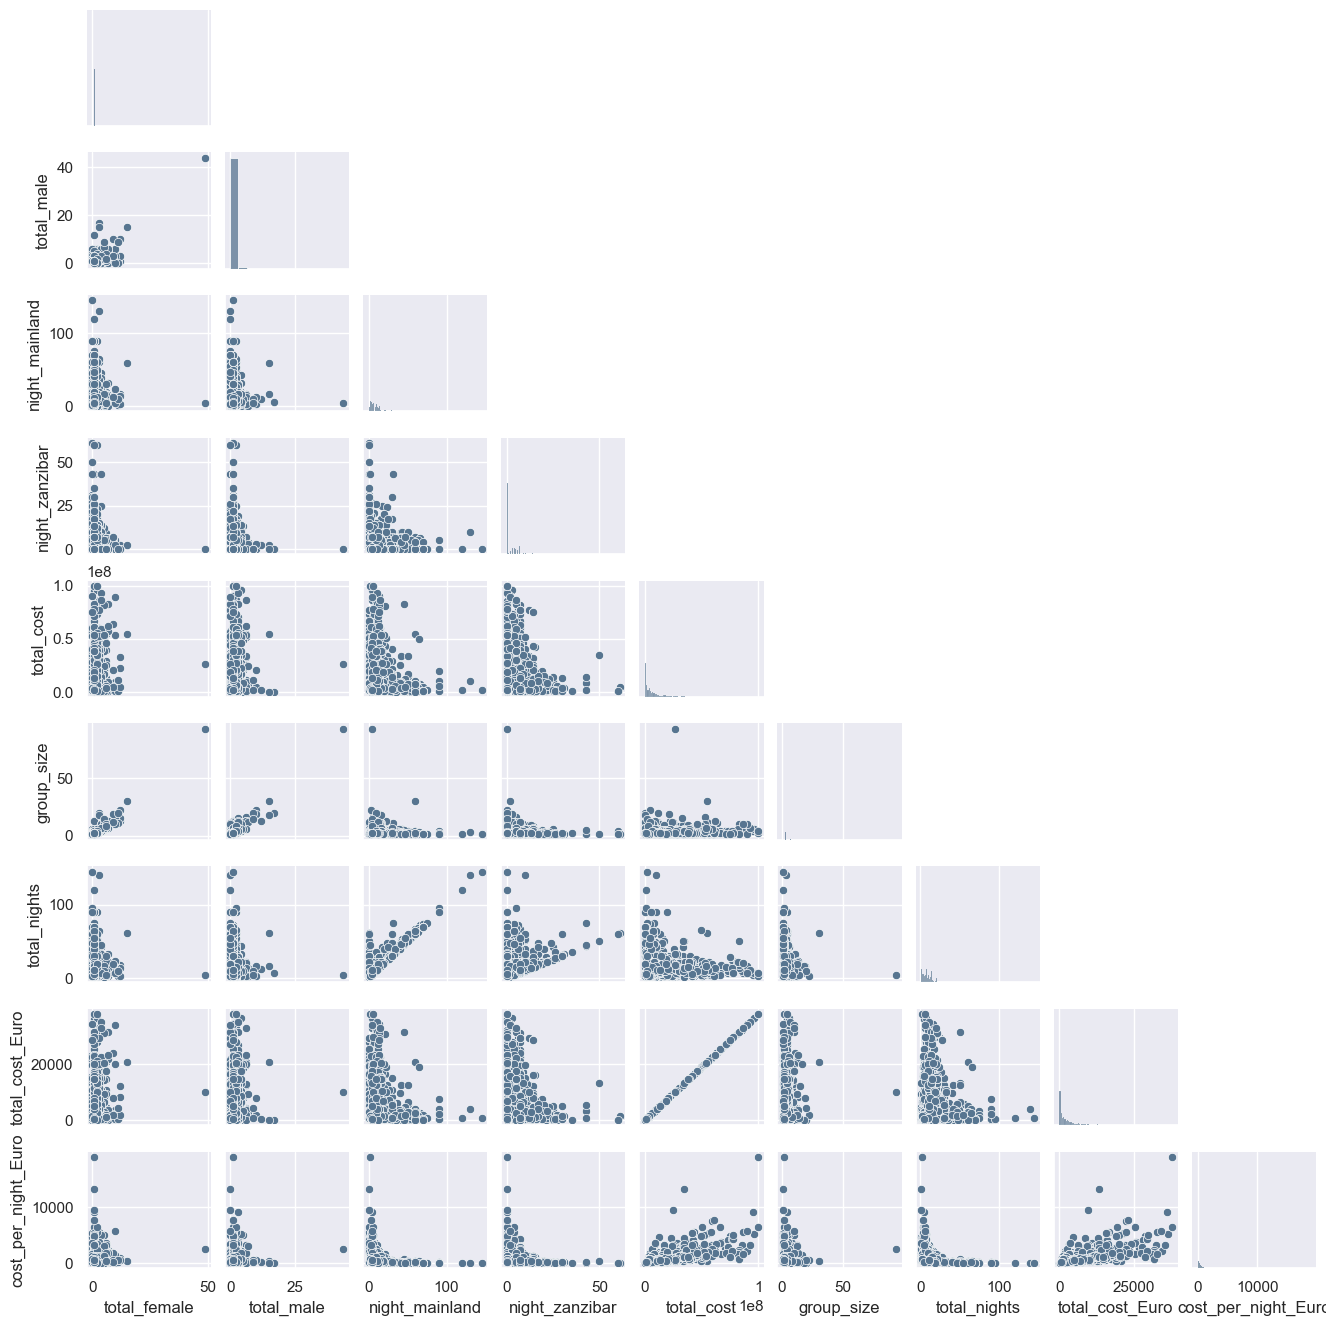

In [66]:
sns.pairplot(TZA, corner=True, height=1.5, palette = cpal, plot_kws={'color':'#577590'}, diag_kws={'color':'#577590'});

No new insights.

Now let's have a look in how far the categorical features impact the total cost. I'll visualize the **median** of total cost (in €) for different categories now. (I choose the median because of the outliers!) If the cost varies greatly by category, we can assume that this feature influences the total cost.

I start with the age group.

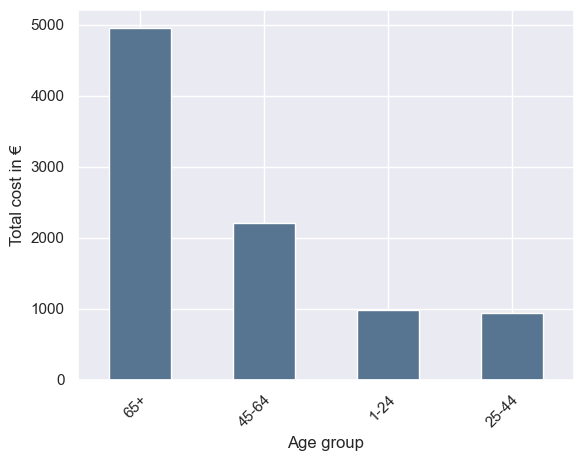

In [67]:
#total cost
age_group = TZA.groupby(['age_group'])['total_cost_Euro'].median()
age_group = age_group.sort_values(ascending=False)
ax = age_group.plot.bar(x='age_group', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Age group')
plt.ylabel('Total cost in €');

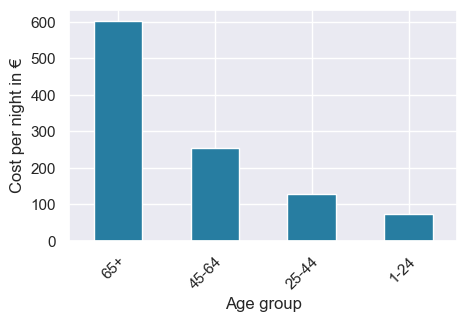

In [68]:
# cost per night
age_group = TZA.groupby(['age_group'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='age_group', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Age group')
plt.ylabel('Cost per night in €');

The older the tourist, the more they spend on their holidays. (Hypothesis confirmed.)

Now I check the travel_with feature accordlingly.

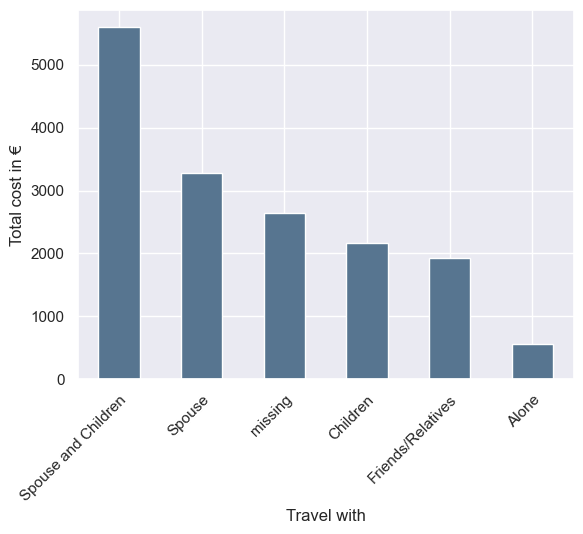

In [69]:
# total cost
travel_with = TZA.groupby(['travel_with'])['total_cost_Euro'].median()
travel_with = travel_with.sort_values(ascending=False)
ax = travel_with.plot.bar(x='travel_with', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Travel with')
plt.ylabel('Total cost in €');

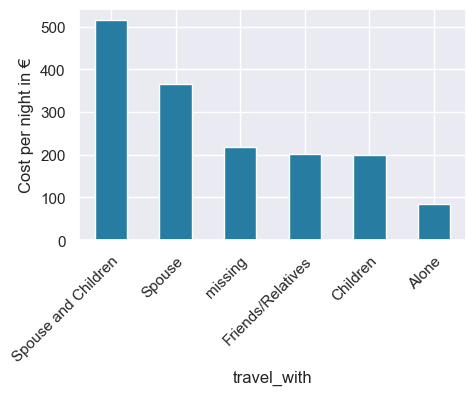

In [70]:
# cost per night
age_group = TZA.groupby(['travel_with'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='travel_with', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('travel_with')
plt.ylabel('Cost per night in €');

While the group size didn't have a great effect, we can see here a correlation: Tourists who travel with their entire family spend significantly more than others, while alone travellers spend least. (This partially confirms one of my hypotheses.)

Now let's see the impact of the travel purpose.

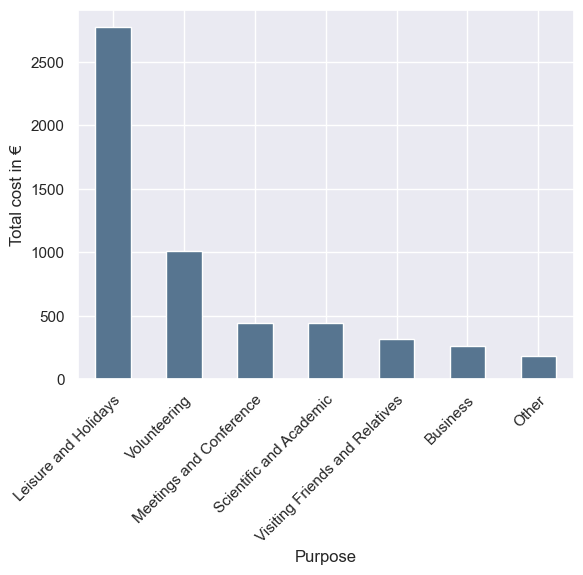

In [71]:
# total cost
purpose = TZA.groupby(['purpose'])['total_cost_Euro'].median()
purpose = purpose.sort_values(ascending=False)
ax = purpose.plot.bar(x='purpose', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Purpose')
plt.ylabel('Total cost in €');

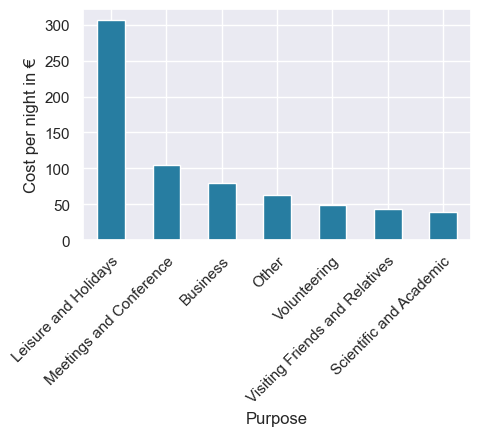

In [72]:
# cost per night
age_group = TZA.groupby(['purpose'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='purpose', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Purpose')
plt.ylabel('Cost per night in €');

Those who visit Tanzania for Leisure and Holidays spend by far the most. Those who come for volunteering spend quite a lot in total, but not per night which indicates that these tourists stay relatively long.

And now we check the main activities accordingly.

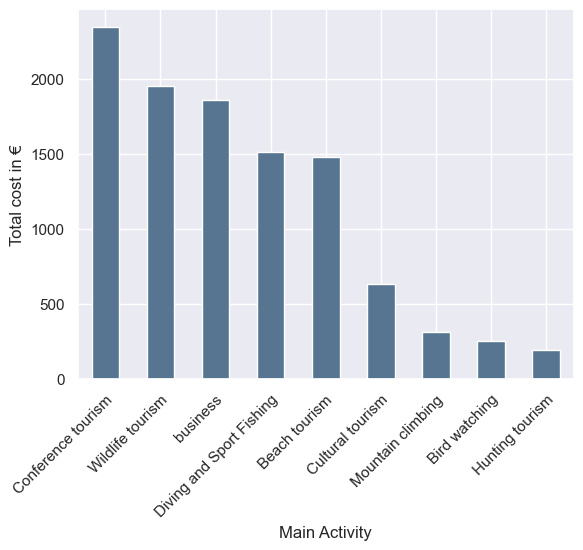

In [73]:
# total cost
activity = TZA.groupby(['main_activity'])['total_cost_Euro'].median()
activity = activity.sort_values(ascending=False)
ax = activity.plot.bar(x='main_activity', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Main Activity')
plt.ylabel('Total cost in €');

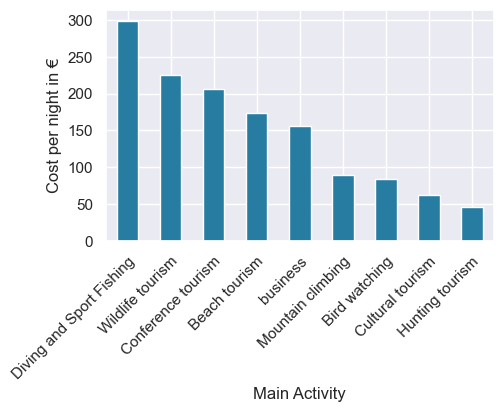

In [74]:
# cost per night
age_group = TZA.groupby(['main_activity'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='main_activity', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Main Activity')
plt.ylabel('Cost per night in €');

I'm not surprised that mountain climbers and bird watchers don't spend that much while I had a totally different picture of (big game) hunters in my head... We see that the main activity has an impact on the total cost. Conference tourists spend most in total, but divers and sport fishers spend most per night.

We remember that the purpose and main activity columns somehow don't fit together. E.g. People who have entered business in main activity may be completely different people than those who have entered purpose business.

The crucial question is: What is closer to the truth? Ultimately, I think the decisive factor for the total costs is what a tourist *actually did* during their visit and not what purpose they may have traveled with.

With purpose, one thing seems to be most important anyway: leisure and holidays - or something else? For main activity, on the other hand, there are major differences between the individual categories. So I believe that this variable is ultimately more meaningful. 

I wonder if the source of information has an impact on the cost?

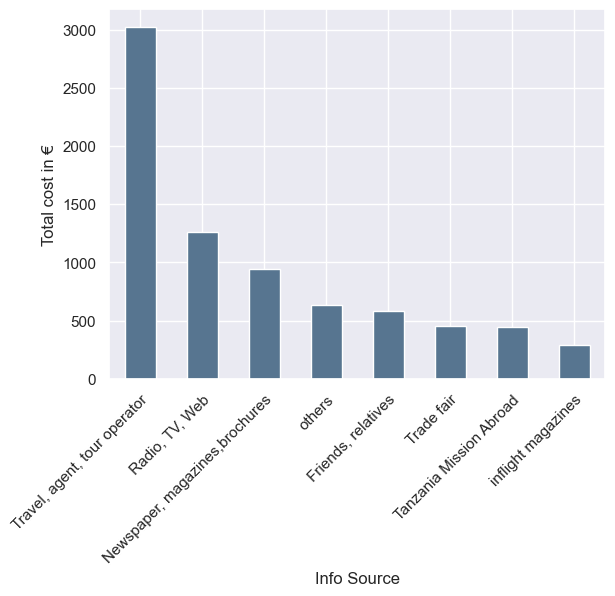

In [75]:
# total cost
info_source = TZA.groupby(['info_source'])['total_cost_Euro'].median()
info_source = info_source.sort_values(ascending=False)
ax = info_source.plot.bar(x='info_source', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Info Source')
plt.ylabel('Total cost in €');

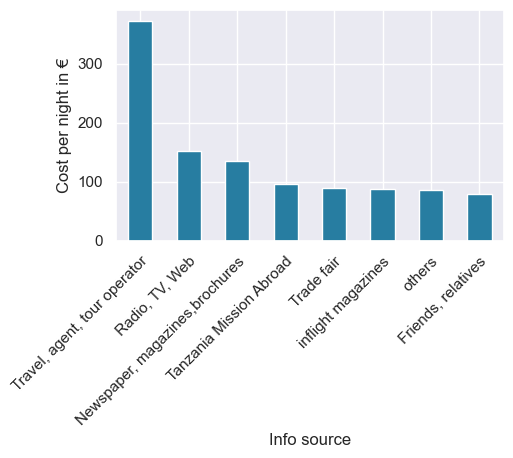

In [76]:
# cost per night
age_group = TZA.groupby(['info_source'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='info_source', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Info source')
plt.ylabel('Cost per night in €');

Those who make use of an agency or tour operator spend by far most. I assume that people who use these services are a bit more affluent anyway. Those who get their information from friends and relatives spend least per night - maybe they also spend the night with these.

Now let's check whether the hypothesis that travellers with arranged tours spend more than independend travellers is confirmed.

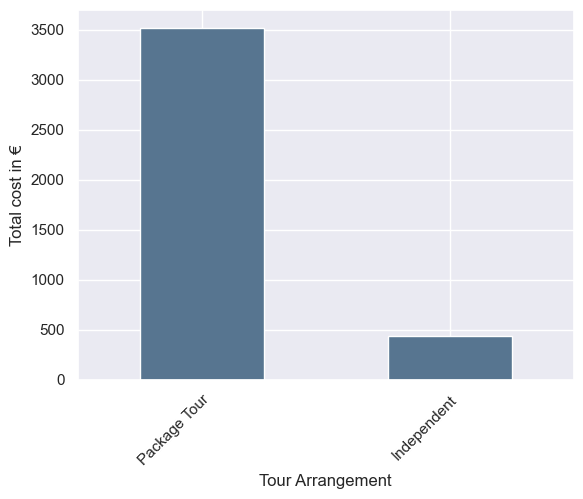

In [77]:
# total cost
tour_arrangement = TZA.groupby(['tour_arrangement'])['total_cost_Euro'].median()
tour_arrangement = tour_arrangement.sort_values(ascending=False)
ax = tour_arrangement.plot.bar(x='tour_arrangement', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Tour Arrangement')
plt.ylabel('Total cost in €');

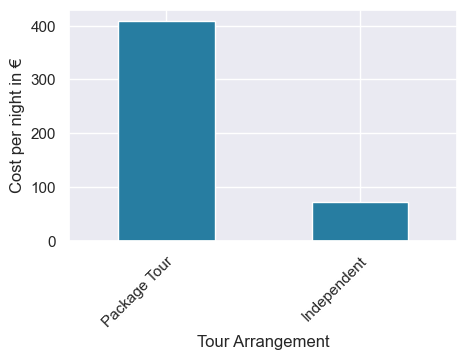

In [78]:
# cost per night
age_group = TZA.groupby(['tour_arrangement'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='tour_arrangement', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Tour Arrangement')
plt.ylabel('Cost per night in €');

Definitely!

Now I'll create some plots which show in how far the total costs are affected by the services which are included. However, not only those travelers who indicated that they had used an arrangement are included here, but also independent travelers. I plot these only for the total cost.

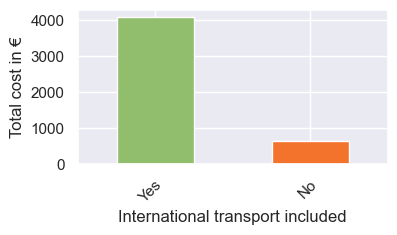

In [79]:
package_transport_int = TZA.groupby(['package_transport_int'])['total_cost_Euro'].median()
package_transport_int = package_transport_int.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_transport_int.plot.bar(x='package_transport_int', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('International transport included')
plt.ylabel('Total cost in €');

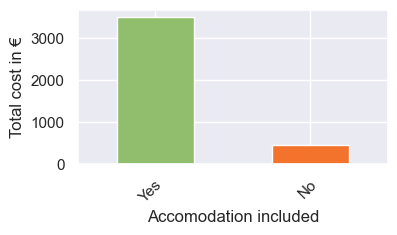

In [80]:
package_accomodation = TZA.groupby(['package_accomodation'])['total_cost_Euro'].median()
package_accomodation = package_accomodation.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_accomodation.plot.bar(x='package_accomodation', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Accomodation included')
plt.ylabel('Total cost in €');

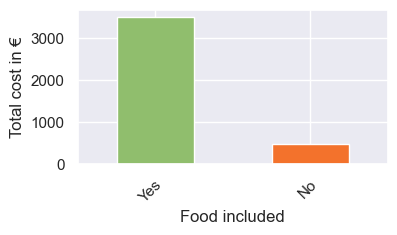

In [81]:
package_food = TZA.groupby(['package_food'])['total_cost_Euro'].median()
package_food = package_food.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_food.plot.bar(x='package_food', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Food included')
plt.ylabel('Total cost in €');

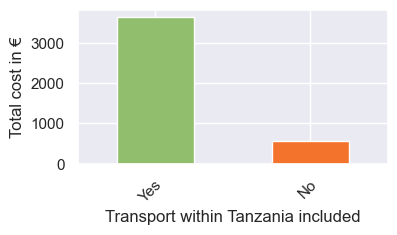

In [82]:
package_transport_tz = TZA.groupby(['package_transport_tz'])['total_cost_Euro'].median()
package_transport_tz = package_transport_tz.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_transport_tz.plot.bar(x='package_transport_tz', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Transport within Tanzania included')
plt.ylabel('Total cost in €');

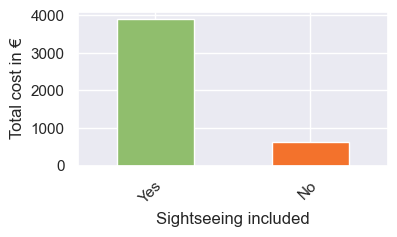

In [83]:
package_sightseeing = TZA.groupby(['package_sightseeing'])['total_cost_Euro'].median()
package_sightseeing = package_sightseeing.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_sightseeing.plot.bar(x='package_sightseeing', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Sightseeing included')
plt.ylabel('Total cost in €');

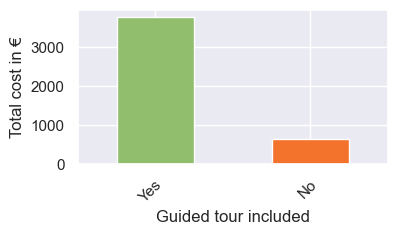

In [84]:
package_guided_tour = TZA.groupby(['package_guided_tour'])['total_cost_Euro'].median()
package_guided_tour = package_guided_tour.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_guided_tour.plot.bar(x='package_guided_tour', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Guided tour included')
plt.ylabel('Total cost in €');

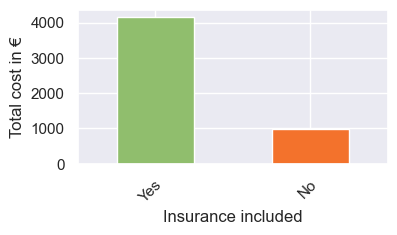

In [85]:
package_insurance = TZA.groupby(['package_insurance'])['total_cost_Euro'].median()
package_insurance = package_insurance.sort_values(ascending=False)
plt.figure(figsize=(4,2))
ax = package_insurance.plot.bar(x='package_insurance', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Insurance included')
plt.ylabel('Total cost in €');

We see that having booked these services impacts the costs. This is not surprising. (If we wanted to examine more closely only those travelers with tour arrangements, we could do the previous plots again with just those travelers. I don't do that now, though, and I'll let the model judge the exact impact of each service later.)

I'm curious if the payment method impacts the total costs.

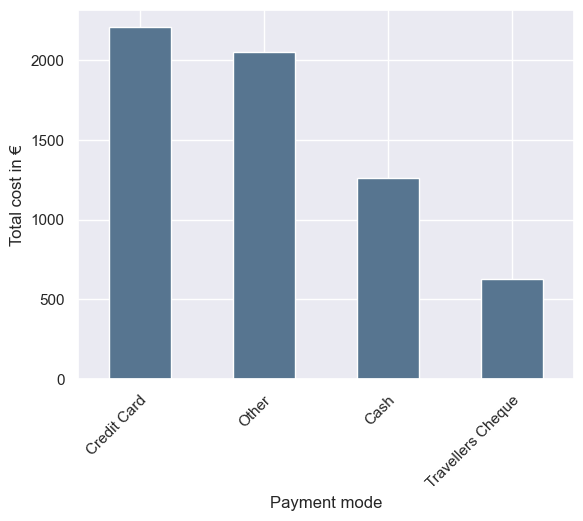

In [86]:
# total cost
payment_mode = TZA.groupby(['payment_mode'])['total_cost_Euro'].median()
payment_mode = payment_mode.sort_values(ascending=False)
ax = payment_mode.plot.bar(x='payment_mode', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Payment mode')
plt.ylabel('Total cost in €');

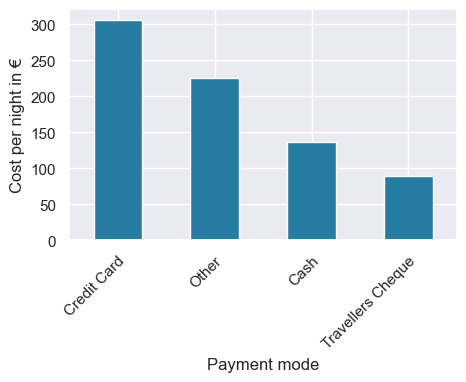

In [87]:
# cost per night
age_group = TZA.groupby(['payment_mode'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='payment_mode', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Payment mode')
plt.ylabel('Cost per night in €');

As we can see, credit card users spend most, followed by 'other' (whatever this is...), travellers cheque users spend least.
Now let's see whether first time visitors spend more or less than repeat vistors.

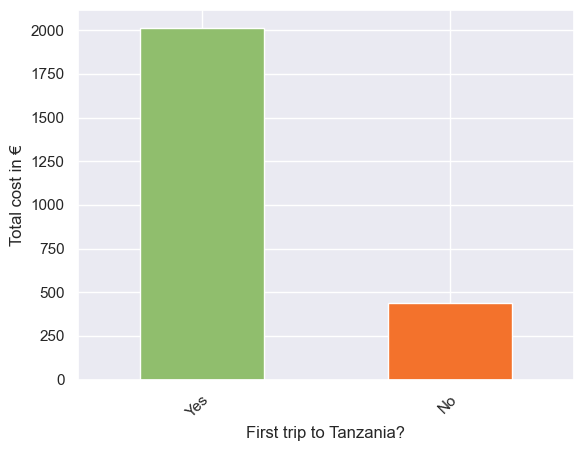

In [88]:
first_trip_tz = TZA.groupby(['first_trip_tz'])['total_cost_Euro'].median()
first_trip_tz = first_trip_tz.sort_values(ascending=False)
ax = first_trip_tz.plot.bar(x='first_trip_tz', y='total_cost_Euro', rot=0, color=["#90be6d", '#f3722c'])
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('First trip to Tanzania?')
plt.ylabel('Total cost in €');

They do!

I wonder if what tourists find most impressive has an impact on the overall cost?

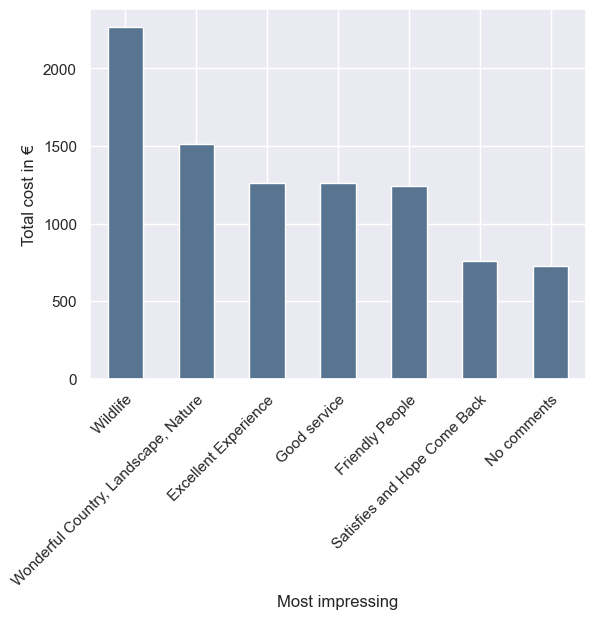

In [89]:
#total cost
most_impressing = TZA.groupby(['most_impressing'])['total_cost_Euro'].median()
most_impressing = most_impressing.sort_values(ascending=False)
ax = most_impressing.plot.bar(x='most_impressing', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Most impressing')
plt.ylabel('Total cost in €');

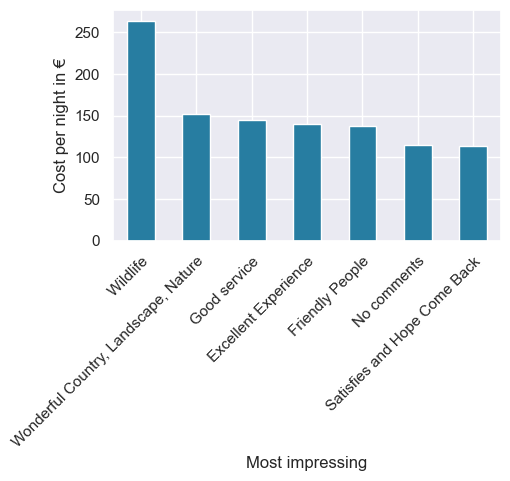

In [90]:
# cost per night
age_group = TZA.groupby(['most_impressing'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='most_impressing', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Most impressing')
plt.ylabel('Cost per night in €');

Not too much. We already know that wildlife tourists are relatively generous. I would imagine that this feature won't play a big role for the model.

The tourists of which sub region of origin probably spend the most?

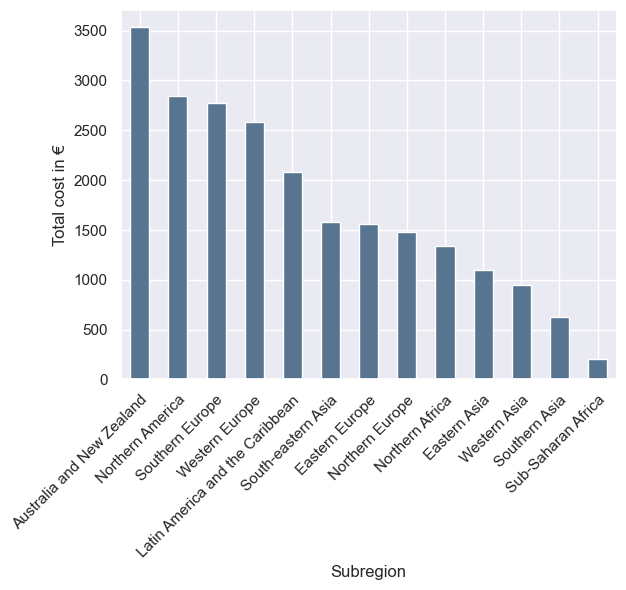

In [91]:
#total cost
sub_region = TZA.groupby(['sub_region'])['total_cost_Euro'].median()
sub_region = sub_region.sort_values(ascending=False)
ax = sub_region.plot.bar(x='sub_region', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Subregion')
plt.ylabel('Total cost in €');

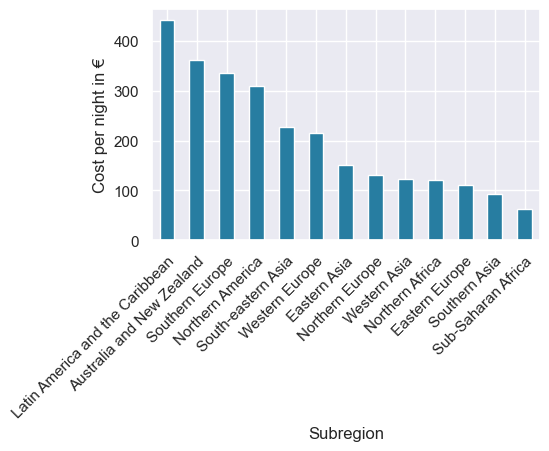

In [92]:
# cost per night
age_group = TZA.groupby(['sub_region'])['cost_per_night_Euro'].median()
age_group = age_group.sort_values(ascending=False)
plt.figure(figsize=(5, 3))
ax = age_group.plot.bar(x='sub_region', y='cost_per_night_Euro', rot=0, color='#277da1')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Subregion')
plt.ylabel('Cost per night in €');

Those from Australia and New Zealand spend the most in total, but tourists from Latin America and the Caribbean spend the most per night (surprising?) Tourists from Tanzanias own region, Sub-Saharan Africa, spend the least.

Now let's check whether the duration of the stay impacts the total cost.

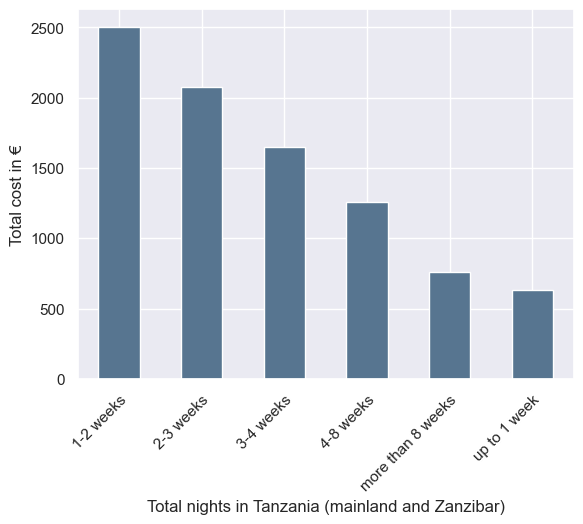

In [93]:
total_nights_binned = TZA.groupby(['total_nights_binned'])['total_cost_Euro'].median()
total_nights_binned = total_nights_binned.sort_values(ascending=False)
ax = total_nights_binned.plot.bar(x='total_nights_binned', y='total_cost_Euro', rot=0, color='#577590')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.xlabel('Total nights in Tanzania (mainland and Zanzibar)')
plt.ylabel('Total cost in €');

It seems that the shorter the stay (except for less than 1 week) the more money is spent. (I expected the opposite.)

It is possible that the wealthy tourists tend to spend short but quality vacations in Tanzania. 

We have learned - and I think this is really interesting - that by far most visitors come from the neighboor countries, but exactly those spend by far the least. It seems to be a group of alone travellers who only stay a couple of days. Maybe these people visit friends or family or come for work? 

### Clustering

Maybe it's interesting to use a cluster algorithm to find some "typical" Tanzania tourists.

I'll first create a new df with only those columns of interest.

In [94]:
# create df for clustering
TZA_for_cluster = TZA[['sub_region', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'total_nights','night_mainland', 'night_zanzibar', 'cost_per_night_Euro']].copy()

In [95]:
# check datatypes and missing values
TZA_for_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4781 entries, 0 to 4791
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sub_region           4781 non-null   object 
 1   age_group            4781 non-null   object 
 2   travel_with          4781 non-null   object 
 3   purpose              4781 non-null   object 
 4   main_activity        4781 non-null   object 
 5   info_source          4781 non-null   object 
 6   tour_arrangement     4781 non-null   object 
 7   total_nights         4781 non-null   float64
 8   night_mainland       4781 non-null   float64
 9   night_zanzibar       4781 non-null   float64
 10  cost_per_night_Euro  4781 non-null   float64
dtypes: float64(4), object(7)
memory usage: 577.3+ KB


No missing values since we already cleaned this up before.

I first want to scale the numeric data. For this I create a copy of the new dataframe first. (For better interpretation of the clusters later I'll need to concatenate the results with the unscaled data.

In [96]:
TZA_for_cluster_scaled = TZA_for_cluster.copy()

In [97]:
# import scaler
from sklearn import preprocessing

#define scaler
scaler = preprocessing.StandardScaler()

# apply scaler on numerical columns
TZA_for_cluster_scaled[['total_nights', 'night_mainland', 'night_zanzibar', 'cost_per_night_Euro']] = scaler.fit_transform(TZA_for_cluster_scaled[['total_nights', 'night_mainland', 'night_zanzibar', 'cost_per_night_Euro']])

In [98]:
# import KPrototypes, an unsupervised model that can handle numerical and categorical data
from kmodes.kprototypes import KPrototypes

In [99]:
TZA_for_cluster_scaled.columns

Index(['sub_region', 'age_group', 'travel_with', 'purpose', 'main_activity',
       'info_source', 'tour_arrangement', 'total_nights', 'night_mainland',
       'night_zanzibar', 'cost_per_night_Euro'],
      dtype='object')

In [100]:
# in order to find the perfect number of clusters, I'll use the elbow method

# I comment the following out since it takes too long when I restart the kernel
#cost = []
K = range(1,9)
#for num_clusters in list(K):
#    kproto = KPrototypes (n_clusters=num_clusters, init = "Cao", n_init = 5, verbose=1)
#    kproto.fit_predict(TZA_for_cluster_scaled, categorical=[0,1,2,3,4,5,6])
#    cost.append(kproto.cost_)

In [101]:
# I save the cost computed in the previous step in a variable
cost = [27931.000000000022,
 22397.00935197131,
 18762.300164816537,
 16206.807772069038,
 14353.818250498229,
 13084.42428686142,
 12120.724253817309,
 11440.326897783418]

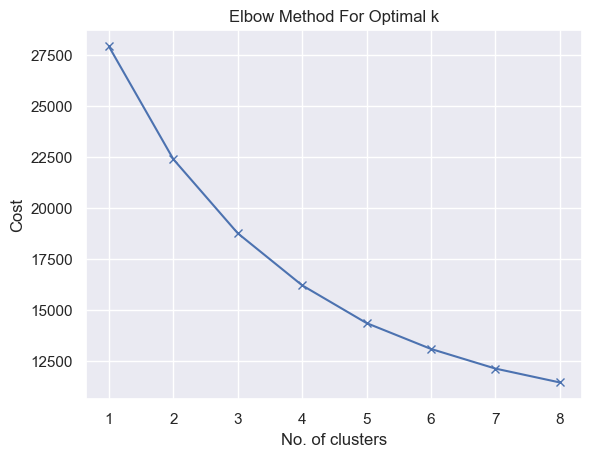

In [102]:
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Not too easy to interpret. I would say we can try 5 clusters.

In [103]:
# fit/predict clustering with 5 clusters
kproto = KPrototypes(n_clusters=5, init='Cao')
clusters = kproto.fit_predict(TZA_for_cluster_scaled, categorical=[0,1,2,3,4,5,6])

In [104]:
#reset index
TZA_for_cluster.reset_index(drop=True, inplace=True)

# convert clusters to series
df_cluster = pd.Series(clusters, name='Cluster')

# concatenate clusters and TZA_for_cluster to obtain a dataframe with the original (unscaled) data and a new column "clusters"
TZA_clustered = pd.concat([TZA_for_cluster, df_cluster], axis=1)

In [105]:
TZA_clustered.columns

Index(['sub_region', 'age_group', 'travel_with', 'purpose', 'main_activity',
       'info_source', 'tour_arrangement', 'total_nights', 'night_mainland',
       'night_zanzibar', 'cost_per_night_Euro', 'Cluster'],
      dtype='object')

In [106]:
# map segments to clusters
TZA_clustered['Segment'] = TZA_clustered['Cluster'].map({0:'First', 1:'Second', 2:'Third', 3: 'Fourth', 4: 'Fifth'})

# save segments as categorical data
TZA_clustered['Segment'] = TZA_clustered['Segment'].astype('category')

# group by segment and aggregate data (mean for numerical, mode for categorical)
cluster_5 = TZA_clustered.groupby('Segment').agg(
    {'Cluster':'count',
    'sub_region': lambda x: x.value_counts().index[0],
    'age_group': lambda x: x.value_counts().index[0],
    'travel_with': lambda x: x.value_counts().index[0],
    'main_activity': lambda x: x.value_counts().index[0],
    'purpose': lambda x: x.value_counts().index[0],
    'info_source': lambda x: x.value_counts().index[0],
    'tour_arrangement': lambda x: x.value_counts().index[0],
    'total_nights': 'median',
    'night_mainland': 'median',
    'night_zanzibar': 'median',
    'cost_per_night_Euro': 'median',
    }
).reset_index()

Since the model produces slightly different clusters each time I run it, I have saved one of the results as CSV locally and load it now to interpret the results:

In [107]:
final_clusters = pd.read_csv('cluster_5.csv')

In [108]:
final_clusters

,Unnamed: 0,Segment,Cluster,sub_region,age_group,travel_with,main_activity,purpose,info_source,tour_arrangement,total_nights,night_mainland,night_zanzibar,cost_per_night_Euro
0,0,Fifth,1693,Sub-Saharan Africa,25-44,Alone,Wildlife tourism,Business,"Friends, relatives",Independent,3.00,3.00,0.00,83.68
1,1,First,144,Northern Europe,25-44,Alone,Wildlife tourism,Visiting Friends and Relatives,"Friends, relatives",Independent,50.00,46.00,0.00,23.62
2,2,Fourth,874,Southern Europe,25-44,Spouse,Beach tourism,Leisure and Holidays,"Travel, agent, tour operator",Package Tour,11.00,1.00,7.00,311.06
3,3,Second,1818,Northern America,25-44,Alone,Wildlife tourism,Leisure and Holidays,"Travel, agent, tour operator",Package Tour,13.00,11.00,0.00,201.65
4,4,Third,236,Northern America,45-64,Spouse,Wildlife tourism,Leisure and Holidays,"Travel, agent, tour operator",Package Tour,6.00,5.00,0.00,2154.61


Let's interpret the clusters:

- First: Middle-aged alone and independent travelers, from Northern Europe, stay relatively long, but do not spend much money. Stay mostly on the mainland. It's a small proportion of tourists.
- Second: Middle-aged alone travelers from Northern America, booked a package, stay almost 2 weeks, spend quite the average money. Stay mostly on the mainland. Very big proportion of tourists.
- Third: Older couples from Northern America, booked a package, stay less than a week. Stay mostly on the mainland. Spend by far the most. Not a very big group, but very generous.
- Fourth: Middle-aged couples from Southern Europe, booked a package, stay almost two weeks, spend many nights on Zanzibar. The only group that spends most time at the beach. Average expenses.
- Fifth: Middle-aged alone and independent travelers from Sub-Saharan Africa, stay very short. Stay only on the mainland. While it says their main activity was Wildlife tourism the purpose of their travel purpose is business which makes more sense to me. One of the biggest group.


The fifth cluster is very interesting. We could see that trend before: Tanzania has many tourists from their own region. These stay short and don't spend very much money. We see thy come for business, but their main activity is wildlife tourism, this does not really make sense. We also saw earlier that hunters do not spend much money in Tanzania. Maybe "wildlife tourism" actually means hunting in this cluster and that's the business they're coming for? We don't dive into this deeper now but it's definitely an interesting group.

The first cluster is also very interesting. I suppose it's expat Tanzanians visiting their families. (There's a big Tanzanian community in the UK.) I suppose they stay in their friend's houses, not in hotels. That's why they don't spend much money there.

The other "extreme" is the third cluster. These tourists are probably wealthy and therefore very valuable for Tanzania's tourism industry. Certainly very welcome in the country.

The other clusters cover some shades between these extremes and seem reasonable.

The clusters confirm a bit what we have seen earlier, but do not generate stunning new insights. It's clear that - although each observation in the dataset was assigned to one of these clusters - not each tourist really actually fits these clusters. Probably most don't - but clusters can help confirming assumptions, inspire new considerations and are a lot of fun, too. :)

## Conclusion

We have seen in this notebook that almost all features show more or less correlation to the target variable "total_cost". On the other hand, some of the features seem interpendent and we do not know what's cause and what's effect. If the main purpose of this project was to make a very deep analysis of the data we could find out more, of course. Based on the findings, new questions keep arising. But at some point, I have to stop the EDA and turn to the model. 
It will be interesting to see how the model will deal with the data since it contains a lot of contradictions...